In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec
import seaborn as sns
from IPython.display import display
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 1 Caga y Exploración

**Exploración:** Valores nulos, Duplicados, Rango de las variables, Incoherencias, Distribución inicial de columnas

## 1.1 Contexto de las variables
El presente conjunto de datos procede del registro personal de gastos realizado de forma manual y sistemática por el usuario a lo largo de un periodo prolongado de tiempo. Su registro fue en dos fuentes diferenciadas:

•	Por un lado, se utilizó la aplicación móvil **Money Manager**, donde se registraron todas las transacciones económicas. En esta herramienta se clasificaron como Expenses los desembolsos personales y como Income las transacciones compartidas o reembolsadas, exceptuando casos concretos como *Blablacar* y *Wallapop*, que fueron tratados explícitamente como ingresos. En adelante, este primer conjunto de datos será denominado “gastos”, ya que recoge el gasto global y consolidado del individuo.

![1 Money Manager.png](../imagenes/1 Money Manager.png)

•	La segunda fuente corresponde a una **hoja de cálculo almacenada en Google Drive** diseñada para documentar el consumo de combustible por trayectos. Este documento contiene distintas pestañas, entre ellas Combo (vehículo principal del usuario), donde se registraron todos los desplazamientos, y *Subaru* y *Pixo*, correspondientes a vehículos adicionales utilizados esporádicamente y con menor frecuencia de anotación. A partir de este punto, este dataset será referido como “coche”, dado que representa el coste asociado al uso de vehículo privado.

![2 Hoja Drive.png](../imagenes/2 Hoja Drive.png)

## 1.2 Carga y identificar estructura del dataset: dimensiones y columnas

### 1.2.1 Carga
 Importar el dataset.

In [115]:
# Rutas posibles (GitHub / Drive)
rutas_xlsx = [
    "data/dataset.xlsx",  # GitHub
    "/content/drive/MyDrive/Proyecto 1 - Limpieza - Finanzas Personales/data/dataset.xlsx"  # Drive Albert
]

rutas_csv = [
    "data/dataset_en_csv.csv",  # GitHub
    "/content/drive/MyDrive/Proyecto 1 - Limpieza - Finanzas Personales/data/dataset.csv"  # Drive Albert
]

In [116]:
gastos = None
# 1) Intentar cargar versión CSV
for ruta in rutas_csv:
    if os.path.exists(ruta):
        gastos = pd.read_csv(ruta)
        print(f"✔ CSV encontrado y cargado: {ruta}")
        break

# 2) Si no se carga el CSV, cargar XLSX, crear CSV y guardar
if gastos is None:
    for ruta in rutas_xlsx:
        if os.path.exists(ruta):
            print(f"⚙ Cargando Excel original desde: {ruta}")
            gastos = pd.read_excel(ruta)

            # Guardar CSV limpio
            salida = rutas_csv[rutas_xlsx.index(ruta)]
            gastos.to_csv(salida, index=False, encoding="utf-8")

            print(f"📁 CSV generado correctamente en: {salida}")
            break

# 3) Si nada funciona → mensaje
if gastos is None:
    raise FileNotFoundError("❌ No se encontró ni dataset.xlsx ni dataset_en_csv.csv en ninguna ruta.")
else:
    print("\n🏁 Dataset disponible y listo para trabajar.")
    display(gastos.head())

✔ CSV encontrado y cargado: /content/drive/MyDrive/Proyecto 1 - Limpieza - Finanzas Personales/data/dataset.csv

🏁 Dataset disponible y listo para trabajar.


,Date,Income/Expenses,Category,Memo,Amount
0,2025-11-29,Expenses,Transportation,Bici Olot-Girona. Bus de Girona a Olot,-9.10
1,2025-11-29,Expenses,Food,"Ezmorzar. Croissant, Napolitana, Llet",-5.70
2,2025-11-29,Expenses,Gasolina,"43,13 L",-56.03
3,2025-11-16,Expenses,Gasolina,"Pixo. 21,64 L",-28.33
4,2025-11-14,Expenses,Food,Sopar. JL colla. Xino. Yakisoba i gyozas,-13.85


In [117]:
# Renombro la columna Date para que se llame "Date" y no "ï»¿Date"
gastos.rename(columns={'ï»¿Date': 'Date'}, inplace=True)
gastos.head()

,Date,Income/Expenses,Category,Memo,Amount
0,2025-11-29,Expenses,Transportation,Bici Olot-Girona. Bus de Girona a Olot,-9.10
1,2025-11-29,Expenses,Food,"Ezmorzar. Croissant, Napolitana, Llet",-5.70
2,2025-11-29,Expenses,Gasolina,"43,13 L",-56.03
3,2025-11-16,Expenses,Gasolina,"Pixo. 21,64 L",-28.33
4,2025-11-14,Expenses,Food,Sopar. JL colla. Xino. Yakisoba i gyozas,-13.85


### 1.2.2 Revisar dimensiones y columnas

In [118]:
print(f"Filas: {gastos.shape[0]}  |  Columnas: {gastos.shape[1]}")

Filas: 1402  |  Columnas: 5


In [119]:
print(
    f"El dataset contiene {gastos.shape[0]} registros y {gastos.shape[1]} características.\n"
    "Las características o columnas disponibles son:\n"
    f"- " + "\n- ".join(gastos.columns)
)


El dataset contiene 1402 registros y 5 características.
Las características o columnas disponibles son:
- Date
- Income/Expenses
- Category
- Memo
- Amount


|     Columnas    |                                                             Significado / Descripción                                                             |
|:---------------:|:-------------------------------------------------------------------------------------------------------------------------------------------------:|
| Date            | Fecha del gasto. Ingresada manualmente por el usuario y, en ausencia de edición, coincide con la fecha de registro. Formato YYYY-MM-DD.           |
| Income/Expenses | Indica si la operación corresponde a un gasto del usuario (Expenses) o a un importe recibido por reparto de costes (Income). Selección manual.    |
| Category        | Categoría asignada al gasto. Puede ser una categoría predeterminada en inglés o creada por el propio usuario.                                     |
| Memo            | Campo de texto libre con notas descriptivas del gasto. Incluye subcategorías separadas por punto y espacio, junto con comentarios relevantes.     |
| Amount          | Importe económico asociado a la operación. Se expresa en euros: valores negativos representan gastos y valores positivos corresponden a ingresos. |

### 1.3 Inspeccionar tipos de datos
Sobre las 5 variables presentadas, sus tipos de datos deberían ser:
- **Date:** Tipo fecha, datetime
- **Income/Expenses**: Tipo string
- **Category**: Tipo string
- **Memo**: Tipo string
- **Amount**: Tipo decimal, float. Únicamente con dos decimales (ya que se trata de cantidades monetarias)

Se comprueba que es así.

In [120]:
print(gastos.dtypes)

Date                object
Income/Expenses     object
Category            object
Memo                object
Amount             float64
dtype: object


In [121]:
# Como Date ha salido con formato object, se cambia a formato datetime
gastos['Date'] = pd.to_datetime(gastos['Date'], errors='coerce')

In [122]:
print(gastos.dtypes)

Date               datetime64[ns]
Income/Expenses            object
Category                   object
Memo                       object
Amount                    float64
dtype: object


In [123]:
for col in ['Income/Expenses', 'Category', 'Memo']:
    # Verificar si todos los valores son strings
    all_strings = gastos[col].map(lambda x: isinstance(x, str)).all()

    if all_strings:
        print(f"La columna '{col}' contiene únicamente strings.")
    else:
        print(f"La columna '{col}' NO contiene solo strings.")

La columna 'Income/Expenses' contiene únicamente strings.
La columna 'Category' contiene únicamente strings.
La columna 'Memo' contiene únicamente strings.


In [124]:
# Verificar si cada valor tiene más de 2 decimales
mask = gastos['Amount'].map(lambda x: round(x, 2) != x)
invalid_values = gastos[mask]

if invalid_values.empty:
    print("Todos los valores de 'Amount' tienen como máximo dos decimales.")
else:
    print("Estos valores de 'Amount' tienen más de dos decimales:")
    print(invalid_values[['Amount']])

Todos los valores de 'Amount' tienen como máximo dos decimales.


## 1.4 ¿Cuál es el dominio del dataset?
Sobre las 5 variables, su dominio debería ser:
- **Date:** Fechas entre septiembre de 2021 hasta el noviembre de 2025 siendo todas fechas válidas.
- **Income/Expenses:** Sólo debería contener strings "Income" y strings "Expenses".
- **Category:** Debería contener distintas categorías por defecto o escogidas por el usuario. Se espera que, al ser una introducción manual quizás hayan muchas categorías, algunas erróneas, algunas demasiado generales o algunas demasiado específicas.
- **Memo:** El dominio alberga una gran variedad de textos, pocos únicos y de una longitud de texto que puede variar mucho también.
- **Amount:** Se esperan valores negativos y positivos, siendo mayoritariamente (número, media y mediana) valores negativos ya que básicamente se registran los datos. No se esperan valores positivos mayores a 1000 (no recibir más de 1000€ en compartir gastos)  ni negativos mayores a -22.100 (compra de un coche) ya que sería fuera de una cantidad lógica en el contexto de las finanzas personales del usuario.

Se comprueba que es así.

### 1.4.1 Dominio de Date

In [125]:
gastos.describe().T

,count,mean,min,25%,50%,75%,max,std
Date,1402,2023-11-25 18:43:39.115549184,2021-09-30 00:00:00,2023-01-21 12:00:00,2023-10-23 00:00:00,2024-10-13 00:00:00,2025-11-29 00:00:00,NaN
Amount,1402.0,-36.599786,-22055.0,-20.6125,-8.865,-3.8075,505.0,596.042708


In [126]:
desc_date = gastos['Date'].describe()

print("Estadísticas de la columna 'Date':")
print(f"  - Número de registros: {desc_date['count']}")
print(f"  - Fecha mínima: {desc_date['min'].date()}")
print(f"  - Fecha máxima: {desc_date['max'].date()}")

Estadísticas de la columna 'Date':
  - Número de registros: 1402
  - Fecha mínima: 2021-09-30
  - Fecha máxima: 2025-11-29


In [127]:
print(f"El dominio de las fechas se extiende desde {desc_date['min'].date()} hasta {desc_date['max'].date()} con una precisión de 1 día.")

El dominio de las fechas se extiende desde 2021-09-30 hasta 2025-11-29 con una precisión de 1 día.


### 1.4.2 Dominio de Income/Expenses

In [128]:
# Se listan los valores únicos.
valores_unicos = gastos['Income/Expenses'].unique()
print("Valores únicos de la columna Income/Expenses:", valores_unicos)

# Se comprueba su esos valores están dentro del conjunto de valores permitido
permitidos = {"Income", "Expenses"}
solo_valores_correctos = set(valores_unicos).issubset(permitidos)

if solo_valores_correctos:
    print("Todos los valores son 'Income' o 'Expenses'")
else:
    print("Algunos valores no son 'Income' ni 'Expenses'")

Valores únicos de la columna Income/Expenses: ['Expenses' 'Income']
Todos los valores son 'Income' o 'Expenses'


### 1.4.3 Dominio de Category

In [129]:
gastos['Category'].describe()

,Category
count,1402
unique,48
top,Food
freq,396


In [130]:
desc_category = gastos['Category'].describe()

print("Estadísticas de la columna 'Category':")
print(f"  - Número total de registros: {desc_category['count']}")
print(f"  - Número de categorías únicas: {desc_category['unique']}")
print(f"  - Categoría más frecuente: '{desc_category['top']}'")
print(f"  - Frecuencia de la categoría más frecuente: {desc_category['freq']}")

Estadísticas de la columna 'Category':
  - Número total de registros: 1402
  - Número de categorías únicas: 48
  - Categoría más frecuente: 'Food'
  - Frecuencia de la categoría más frecuente: 396


In [131]:
# Se listan los valores únicos.
valores_unicos = gastos['Category'].unique()
print("Valores únicos de la columna Category:", valores_unicos)

Valores únicos de la columna Category: ['Transportation' 'Food' 'Gasolina' 'Prendre algo' 'Atraccions' 'Sexe'
 'Gift' 'Bàsquet' 'Gasolina compartida' 'Cotxe compartit' 'Alcohol'
 'Obligatori' 'Tennis' 'Snacks' 'Supermercat' 'Car' 'Pàrquing' 'Tren'
 'Health' 'Perruqueria' 'Material ruta' 'Home' 'Furgo' 'Peatge'
 'Allotjament' 'Bizum' 'Vols' 'Lloguer cotxe' 'Education'
 'Projecte Boscos' 'Esquiar' 'Salary' 'Bici' 'Roba' 'Work' 'Banc'
 'Casament' 'Blablacar' 'Banc Sabadell' 'Excursió' 'Teatre i Cinema'
 'Salou' 'Jocs cartes / taula' 'pizza' 'Llibreria' 'Paintball'
 'Entertainment' 'Educació']


### 1.4.4 Dominio de Memo

In [132]:
print(gastos['Memo'].describe())


count                        1402
unique                       1351
top       Dinar. Menjador. Feina.
freq                            9
Name: Memo, dtype: object


In [133]:
desc_memo = gastos['Memo'].describe()

print("Estadísticas de la columna 'Memo':")
print(f"  - Número total de registros: {desc_memo['count']}")
print(f"  - Número de valores únicos: {desc_memo['unique']}")
print(f"  - Valor más frecuente: '{desc_memo['top']}'")
print(f"  - Frecuencia del valor más frecuente: {desc_memo['freq']}")

Estadísticas de la columna 'Memo':
  - Número total de registros: 1402
  - Número de valores únicos: 1351
  - Valor más frecuente: 'Dinar. Menjador. Feina.'
  - Frecuencia del valor más frecuente: 9


In [134]:
# Longitud de los memos
gastos['Memo_length'] = gastos['Memo'].astype(str).map(len)
print(gastos['Memo_length'].describe())


count    1402.000000
mean       29.241084
std        16.638760
min         3.000000
25%        17.000000
50%        27.000000
75%        37.750000
max       139.000000
Name: Memo_length, dtype: float64


In [135]:
desc_length = gastos['Memo_length'].describe()

print("Estadísticas de la longitud de los memos (número de caracteres):")
print(f"  - Número total de registros: {desc_length['count']}")
print(f"  - Longitud mínima de un memo: {desc_length['min']} caracteres")
print(f"  - Longitud máxima de un memo: {desc_length['max']} caracteres")
print(f"  - Longitud promedio de los memos: {desc_length['mean']:.2f} caracteres")
print(f"  - Desviación estándar de la longitud: {desc_length['std']:.2f} caracteres")
print(f"  - Primer cuartil (25%): {desc_length['25%']} caracteres")
print(f"  - Mediana (50%): {desc_length['50%']} caracteres")
print(f"  - Tercer cuartil (75%): {desc_length['75%']} caracteres")


Estadísticas de la longitud de los memos (número de caracteres):
  - Número total de registros: 1402.0
  - Longitud mínima de un memo: 3.0 caracteres
  - Longitud máxima de un memo: 139.0 caracteres
  - Longitud promedio de los memos: 29.24 caracteres
  - Desviación estándar de la longitud: 16.64 caracteres
  - Primer cuartil (25%): 17.0 caracteres
  - Mediana (50%): 27.0 caracteres
  - Tercer cuartil (75%): 37.75 caracteres


### 1.4.5 Dominio de Amount

In [136]:
gastos.describe().T

,count,mean,min,25%,50%,75%,max,std
Date,1402,2023-11-25 18:43:39.115549184,2021-09-30 00:00:00,2023-01-21 12:00:00,2023-10-23 00:00:00,2024-10-13 00:00:00,2025-11-29 00:00:00,NaN
Amount,1402.0,-36.599786,-22055.0,-20.6125,-8.865,-3.8075,505.0,596.042708
Memo_length,1402.0,29.241084,3.0,17.0,27.0,37.75,139.0,16.63876


In [137]:
desc_amount = gastos['Amount'].describe()

print("Estadísticas de la columna 'Amount':")
print(f"  - Número de registros: {desc_amount['count']}")
print(f"  - Mínimo: {desc_amount['min']}")
print(f"  - Máximo: {desc_amount['max']}")

Estadísticas de la columna 'Amount':
  - Número de registros: 1402.0
  - Mínimo: -22055.0
  - Máximo: 505.0


In [138]:
print(f"\n El dominio de los datos se estiende desde : {desc_amount['min']} € hasta {desc_amount['max']} € con una precisión de 0.00 €")


 El dominio de los datos se estiende desde : -22055.0 € hasta 505.0 € con una precisión de 0.00 €


## 1.5 ¿La fuente de datos es fiable y completa?

## 1.6 ¿Los datos están agregados o son individuales (nivel de granularidad)?

In [230]:
num_duplicados = gastos.duplicated(subset=['Date', 'Category', 'Amount']).sum()
print(f"Número de filas duplicadas exactas: {num_duplicados}")
if num_duplicados == 0:
    print("No hay duplicados exactos, cada registro parece único.")
else:
    print(f"Hay {num_duplicados} duplicados exactos.")
    print("Esto indica que algunos gastos se registraron más de una vez,\npero es un número pequeño comparado con el total de filas.")

Número de filas duplicadas exactas: 10
Hay 10 duplicados exactos.
Esto indica que algunos gastos se registraron más de una vez,
pero es un número pequeño comparado con el total de filas.


In [222]:
print(gastos.groupby('Date').size().describe())

count    663.000000
mean       2.055807
std        1.671213
min        1.000000
25%        1.000000
50%        2.000000
75%        2.500000
max       21.000000
dtype: float64


In [232]:
gastos_por_fecha = gastos.groupby('Date').size().describe()
print("Número de gastos por fecha:")
print(gastos_por_fecha)
print(f"\nInterpretación:")
print(f" - Total de fechas distintas: {int(gastos_por_fecha['count'])}")
print(f" - Promedio de gastos por fecha: {gastos_por_fecha['mean']:.2f}")
print(f" - La mediana es {gastos_por_fecha['50%']}, lo que indica que la mayoría de los días tienen 1 o 2 registros.")
print(f" - El máximo es {int(gastos_por_fecha['max'])}, lo que indica que hay un día con hasta 21 gastos registrados.")
print("Esto sugiere que los datos son en gran parte individuales, pero algunos días registran múltiples gastos.")


Número de gastos por fecha:
count    663.000000
mean       2.055807
std        1.671213
min        1.000000
25%        1.000000
50%        2.000000
75%        2.500000
max       21.000000
dtype: float64

Interpretación:
 - Total de fechas distintas: 663
 - Promedio de gastos por fecha: 2.06
 - La mediana es 2.0, lo que indica que la mayoría de los días tienen 1 o 2 registros.
 - El máximo es 21, lo que indica que hay un día con hasta 21 gastos registrados.
Esto sugiere que los datos son en gran parte individuales, pero algunos días registran múltiples gastos.


In [233]:
gastos_por_fecha_cat = gastos.groupby(['Date', 'Category']).size().describe()
print("Número de gastos por fecha y categoría:")
print(gastos_por_fecha_cat)
print(f"\nInterpretación:")
print(f" - La mediana es {gastos_por_fecha_cat['50%']}, lo que indica que la mayoría de combinaciones fecha-categoría tienen 1 registro.")
print(f" - El máximo es {int(gastos_por_fecha_cat['max'])}, lo que significa que alguna combinación fecha-categoría tiene hasta 21 registros, probablemente debido a gastos agrupados o repetidos ese día.")
print("En general, cada fila parece representar un gasto individual, con algunas excepciones que podrían indicar duplicados o agregaciones pequeñas.")

Número de gastos por fecha y categoría:
count    1161.000000
mean        1.173988
std         0.846318
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max        21.000000
dtype: float64

Interpretación:
 - La mediana es 1.0, lo que indica que la mayoría de combinaciones fecha-categoría tienen 1 registro.
 - El máximo es 21, lo que significa que alguna combinación fecha-categoría tiene hasta 21 registros, probablemente debido a gastos agrupados o repetidos ese día.
En general, cada fila parece representar un gasto individual, con algunas excepciones que podrían indicar duplicados o agregaciones pequeñas.


## 1.7 ¿Hay valores nulos? ¿Cuál es su proporción?

In [139]:
print(gastos.isnull().sum())

Date               0
Income/Expenses    0
Category           0
Memo               0
Amount             0
Memo_length        0
dtype: int64


In [140]:
if gastos.isnull().sum().sum() == 0:
    print("No hay valores nulos en ninguna columna.")
else:
    proporcion = (gastos.isnull().mean() * 100).round(2)
    print("Proporción de valores nulos por columna (%):")
    for col, pct in proporcion.items():
        print(f"  - {col}: {pct}%")

No hay valores nulos en ninguna columna.


## 1.8 ¿Existen duplicados o registros anómalos?

In [141]:
print(f"Hay {gastos.duplicated().sum()} fila/s duplicada/s en el dataset.")

Hay 1 fila/s duplicada/s en el dataset.


In [142]:
print("Las filas duplicadas en el dataset son:\n")
print(gastos[gastos.duplicated(keep=False)])

Las filas duplicadas en el dataset son:

          Date Income/Expenses   Category                         Memo  \
810 2023-08-07          Income  Blablacar  Alps23. Montpellier-Venècia   
811 2023-08-07          Income  Blablacar  Alps23. Montpellier-Venècia   

     Amount  Memo_length  
810    42.0           27  
811    42.0           27  


## 1.9 ¿Las variables tienen una distribución razonable? ¿Existen outliers?

### 1.9.1 Distribución de Date

In [143]:
gastos.describe().T

,count,mean,min,25%,50%,75%,max,std
Date,1402,2023-11-25 18:43:39.115549184,2021-09-30 00:00:00,2023-01-21 12:00:00,2023-10-23 00:00:00,2024-10-13 00:00:00,2025-11-29 00:00:00,NaN
Amount,1402.0,-36.599786,-22055.0,-20.6125,-8.865,-3.8075,505.0,596.042708
Memo_length,1402.0,29.241084,3.0,17.0,27.0,37.75,139.0,16.63876


In [144]:
desc_date = gastos['Date'].describe()

print("Estadísticas de la columna 'Date':")
print(f"  - Promedio: {desc_date['mean'].date()}")
print(f"  - Primer cuartil (25%): {desc_date['25%'].date()}")
print(f"  - Mediana (50%): {desc_date['50%'].date()}")
print(f"  - Tercer cuartil (75%): {desc_date['75%'].date()}\n")

Estadísticas de la columna 'Date':
  - Promedio: 2023-11-25
  - Primer cuartil (25%): 2023-01-21
  - Mediana (50%): 2023-10-23
  - Tercer cuartil (75%): 2024-10-13



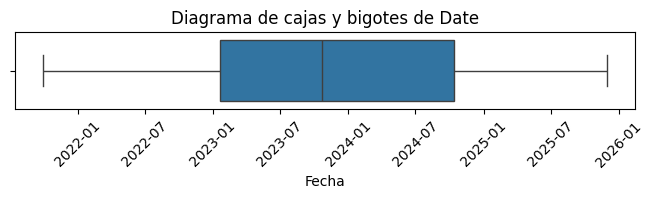

La cantidad de gastos hecha tiene una distribución más o menos uniforme en el tiempo.
No existen outliers.


In [145]:
plt.figure(figsize=(8, 1))
sns.boxplot(x=gastos['Date'])
plt.title("Diagrama de cajas y bigotes de Date")
plt.xlabel("Fecha")
plt.xticks(rotation=45)
plt.show()

print("La cantidad de gastos hecha tiene una distribución más o menos uniforme en el tiempo.")
print("No existen outliers.")

### 1.9.2 Distribución de Income/Expenses

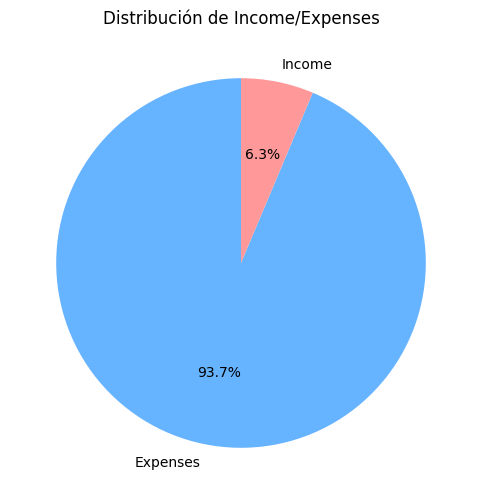

La mayoría de registros corresponen a gastos y una pequeña proporción a compartición de gastos.
No existen outliers.


In [146]:
conteo = gastos['Income/Expenses'].value_counts()

plt.figure(figsize=(6,6))
plt.pie(conteo, labels=conteo.index, autopct='%1.1f%%', startangle=90, colors=['#66b3ff','#ff9999'])
plt.title("Distribución de Income/Expenses")
plt.show()

print("La mayoría de registros corresponen a gastos y una pequeña proporción a compartición de gastos.")
print("No existen outliers.")

### 1.9.3 Distribución de Category

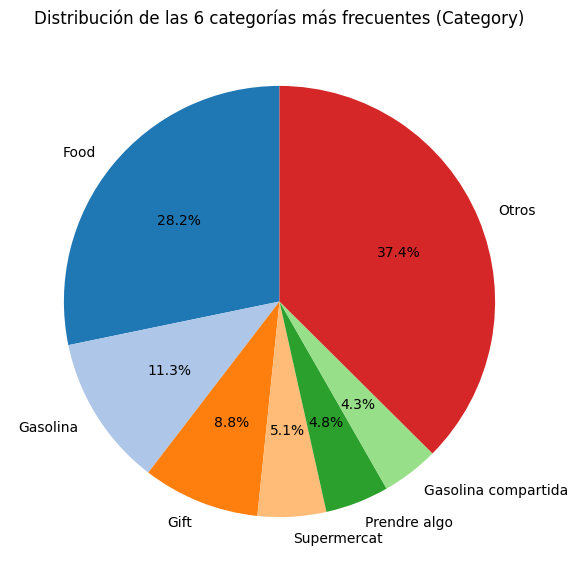

Así se distribuyen el número de gastos (no en cantidad) en las categorías más frecuentes.
No existen outliers aunque existen muchas categorías que se podrían agrupar ya que el número total de categorías existentes es 48.


In [147]:
conteo = gastos['Category'].value_counts()
top6 = conteo.head(6) # Tomar las 6 categorías más frecuentes
top6['Otros'] = conteo[6:].sum() # Agrupar el resto como "Otros"

plt.figure(figsize=(7,7))
plt.pie(top6, labels=top6.index, autopct='%1.1f%%', startangle=90, colors=plt.cm.tab20.colors)
plt.title("Distribución de las 6 categorías más frecuentes (Category)")
plt.show()

print("Así se distribuyen el número de gastos (no en cantidad) en las categorías más frecuentes.")
print(f"No existen outliers aunque existen muchas categorías que se podrían agrupar ya que el número total de categorías existentes es {gastos['Category'].nunique()}.")

### 1.9.4 Distribución de Amount

In [148]:
gastos.describe().T

,count,mean,min,25%,50%,75%,max,std
Date,1402,2023-11-25 18:43:39.115549184,2021-09-30 00:00:00,2023-01-21 12:00:00,2023-10-23 00:00:00,2024-10-13 00:00:00,2025-11-29 00:00:00,NaN
Amount,1402.0,-36.599786,-22055.0,-20.6125,-8.865,-3.8075,505.0,596.042708
Memo_length,1402.0,29.241084,3.0,17.0,27.0,37.75,139.0,16.63876


In [149]:
desc_amount = gastos['Amount'].describe()

print("Estadísticas de la columna 'Amount':")
print(f"  - Promedio: {desc_amount['mean']:.2f}")
print(f"  - Desviación estándar: {desc_amount['std']:.2f}")
print(f"  - Primer cuartil (25%): {desc_amount['25%']}")
print(f"  - Mediana (50%): {desc_amount['50%']}")
print(f"  - Tercer cuartil (75%): {desc_amount['75%']}")

Estadísticas de la columna 'Amount':
  - Promedio: -36.60
  - Desviación estándar: 596.04
  - Primer cuartil (25%): -20.612499999999997
  - Mediana (50%): -8.865
  - Tercer cuartil (75%): -3.8075


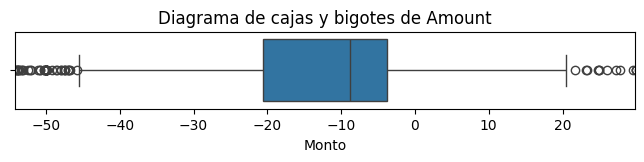

La distribución es razonable. La mayoría de gastos son pequeños. Se ve que:
• Un 25% de los gastos se situan entre -8.87 € y -3.81 € 
• Un 50% de los gastos se situan entre -20.61 € y -3.81 € 

Hay un gran rango de datos que se estiende desde : -22055.0 € hasta 505.0 €


In [150]:
Q1 = gastos['Amount'].quantile(0.25)
Q3 = gastos['Amount'].quantile(0.75)
IQR = Q3 - Q1

plt.figure(figsize=(8, 1))
sns.boxplot(x=gastos['Amount'])
plt.title("Diagrama de cajas y bigotes de Amount")
plt.xlabel("Monto")
plt.xlim(Q1 - 2 * IQR, Q3 + 2 * IQR)  # Limitar eje x
plt.show()

print("La distribución es razonable. La mayoría de gastos son pequeños. Se ve que:")
print(f"• Un 25% de los gastos se situan entre {desc_amount['50%']:.2f} € y {desc_amount['75%']:.2f} € ")
print(f"• Un 50% de los gastos se situan entre {desc_amount['25%']:.2f} € y {desc_amount['75%']:.2f} € ")


print(f"\nHay un gran rango de datos que se estiende desde : {desc_amount['min']} € hasta {desc_amount['max']} €")

In [151]:
print("Excepto un outlier, todos los valores parecen dentro de razonables")

print(f"El outlier es el máximo de 'Amount' de {desc_amount['max']}. Muy alto para una compartición de gastos\n")

print(gastos.loc[gastos['Amount'].idxmax()]) # mostramos el dato de máximo "Amount"

print("\nVemos que este dato es un regalo de Navidad que quizás no debería ir en este registro.")

Excepto un outlier, todos los valores parecen dentro de razonables
El outlier es el máximo de 'Amount' de 505.0. Muy alto para una compartición de gastos

Date               2025-01-06 00:00:00
Income/Expenses                 Income
Category                        Salary
Memo                             Papes
Amount                           505.0
Memo_length                          5
Name: 264, dtype: object

Vemos que este dato es un regalo de Navidad que quizás no debería ir en este registro.


In [152]:
print("La siguiente cantidad de compartición de gastos más alta es:")
print(gastos.nlargest(2, 'Amount').iloc[1])
print("\nque es un valor correcto dentro del contexto de los datos (no outlier)")

La siguiente cantidad de compartición de gastos más alta es:
Date                  2023-08-16 00:00:00
Income/Expenses                    Income
Category                        Blablacar
Memo               Alps23. Milà-Puigcerdà
Amount                               50.0
Memo_length                            22
Name: 775, dtype: object

que es un valor correcto dentro del contexto de los datos (no outlier)


## 1.10 ¿Los formatos (fechas, categorías) están normalizados?

### 1.10.1 Normalización de fechas

Todas las fechas estaban en un formato inválido 'object' pero se cambiaron todas a un formato normalizado de datetime con:
```
gastos['Date'] = pd.to_datetime(gastos['Date'], errors='coerce')
```

In [153]:
print(f"Tras el cambio, el formato de fecha es {gastos['Date'].dtype}.")
print(f"Y el número de fechas inválidas es {len(gastos[gastos['Date'].isna()])}.")

Tras el cambio, el formato de fecha es datetime64[ns].
Y el número de fechas inválidas es 0.


In [154]:
print(f"Las fechas están normalizadas y así podemos trabajar su formato.")
print(gastos['Date'].dt.strftime('%Y-%m-%d').head(5))

Las fechas están normalizadas y así podemos trabajar su formato.
0    2025-11-29
1    2025-11-29
2    2025-11-29
3    2025-11-16
4    2025-11-14
Name: Date, dtype: object


### 1.10.2 Normalización de categorías

In [155]:
print(f"En el apartado 1.4.3 se descubrió que existen muchas ({gastos['Category'].nunique()}) categorías distintas. En concreto estas:\n")
gastos['Category'].unique()


En el apartado 1.4.3 se descubrió que existen muchas (48) categorías distintas. En concreto estas:



array(['Transportation', 'Food', 'Gasolina', 'Prendre algo', 'Atraccions',
       'Sexe', 'Gift', 'Bàsquet', 'Gasolina compartida',
       'Cotxe compartit', 'Alcohol', 'Obligatori', 'Tennis', 'Snacks',
       'Supermercat', 'Car', 'Pàrquing', 'Tren', 'Health', 'Perruqueria',
       'Material ruta', 'Home', 'Furgo', 'Peatge', 'Allotjament', 'Bizum',
       'Vols', 'Lloguer cotxe', 'Education', 'Projecte Boscos', 'Esquiar',
       'Salary', 'Bici', 'Roba', 'Work', 'Banc', 'Casament', 'Blablacar',
       'Banc Sabadell', 'Excursió', 'Teatre i Cinema', 'Salou',
       'Jocs cartes / taula', 'pizza', 'Llibreria', 'Paintball',
       'Entertainment', 'Educació'], dtype=object)

In [156]:
print("• Las categorías no están normalizadas ya que estan en distintos idiomas ")
print("• No existe una forma estándar de clasificar los gastos. Muchas categorías dificulta un buen análisi descriptivo de las finanzas.")

• Las categorías no están normalizadas ya que estan en distintos idiomas 
• No existe una forma estándar de clasificar los gastos. Muchas categorías dificulta un buen análisi descriptivo de las finanzas.


## 1.11 ¿Existen incoherencias entre columnas?

### 1.11.1 Incoherencias de fechas

Se verifica que no haya días de mes incorrectos (29, 30 o 31 de febrero, 31 de abril, 31 de junio, 31 septiembre, 31 noviembre)

In [157]:
# Definir los días máximos por mes
DIAS_POR_MES = {
    1: 31,   # Enero
    2: 29,   # Febrero (máximo 29 considerando bisiesto)
    3: 31,   # Marzo
    4: 30,   # Abril
    5: 31,   # Mayo
    6: 30,   # Junio
    7: 31,   # Julio
    8: 31,   # Agosto
    9: 30,   # Septiembre
    10: 31,  # Octubre
    11: 30,  # Noviembre
    12: 31   # Diciembre
}
def es_fecha_valida(row):
    dia = row['Dia']
    mes = row['Mes']
    any = row['Any']
    # Obtener el máximo día permitido para ese mes
    max_dia = DIAS_POR_MES.get(mes, 31)
    # Si es febrero, comprobar si es año bisiesto
    if mes == 2:
        if max_dia == 29:
            # Año bisiesto: divisible entre 4, pero no entre 100 a menos que también entre 400
            if (any % 4 == 0 and any % 100 != 0) or (any % 400 == 0):
                max_dia = 29
            else:
                max_dia = 28
    return dia <= max_dia

In [158]:
# Crear columnas auxiliares con dia / mes / año
gastos['Dia'] = gastos['Date'].dt.day
gastos['Mes'] = gastos['Date'].dt.month
gastos['Any'] = gastos['Date'].dt.year

# Aplicar la función para verificar si cada fecha es válida
gastos['Fecha_valida'] = gastos.apply(es_fecha_valida, axis=1)

# Buscar fechas incorrectas
errores_fecha = gastos[gastos['Fecha_valida'] == False]

if errores_fecha.empty:
    print("No se encontraron incoherencias en las fechas.")
else:
    print("Se encontraron fechas inválidas:")
    print(errores_fecha[['Date', 'Dia', 'Mes', 'Any']])

No se encontraron incoherencias en las fechas.


### 1.11.2 Incoherencias de categorías de Income

In [159]:
# Categorías de Income
gastos.loc[gastos['Income/Expenses'] == 'Income', 'Category'].unique()

array(['Gasolina compartida', 'Bizum', 'Salary', 'Blablacar',
       'Banc Sabadell'], dtype=object)

In [160]:
print("El registro completo de compartición de datos en blablacar se hace en otro lugar, así que aquí solo hay el registro parcial que no conviene mantener")
print("Sobre las otras categorías de Income que no son ni blablacar ni gasolina compartida, tenemos:")
gastos[(gastos["Income/Expenses"]=="Income") & (gastos["Category"]!="Blablacar")& (gastos["Category"]!="Gasolina compartida")]

El registro completo de compartición de datos en blablacar se hace en otro lugar, así que aquí solo hay el registro parcial que no conviene mantener
Sobre las otras categorías de Income que no son ni blablacar ni gasolina compartida, tenemos:


,Date,Income/Expenses,Category,Memo,Amount,Memo_length,Dia,Mes,Any,Fecha_valida
94,2025-08-17,Income,Bizum,Campingaz. Oriol,5.00,16,17,8,2025,True
264,2025-01-06,Income,Salary,Papes,505.00,5,6,1,2025,True
845,2023-07-14,Income,Banc Sabadell,Promo,39.91,5,14,7,2023,True
1087,2022-12-26,Income,Bizum,Roser gasolina,11.00,14,26,12,2022,True


In [161]:
print("Es una promoción del banco. Se tendría que borrar el registro ya que ya está incluido en los ingresos junto con los demás intereses de la cuenta.")
gastos[gastos["Category"]=="Banc Sabadell"]

Es una promoción del banco. Se tendría que borrar el registro ya que ya está incluido en los ingresos junto con los demás intereses de la cuenta.


,Date,Income/Expenses,Category,Memo,Amount,Memo_length,Dia,Mes,Any,Fecha_valida
845,2023-07-14,Income,Banc Sabadell,Promo,39.91,5,14,7,2023,True


In [162]:
print("Es una división del gasto de la gasolina. Se reconfigura la categoría como 'Gasolina compartida.")
display(gastos[gastos["Category"]=="Bizum"])

Es una división del gasto de la gasolina. Se reconfigura la categoría como 'Gasolina compartida.


,Date,Income/Expenses,Category,Memo,Amount,Memo_length,Dia,Mes,Any,Fecha_valida
94,2025-08-17,Income,Bizum,Campingaz. Oriol,5.0,16,17,8,2025,True
1087,2022-12-26,Income,Bizum,Roser gasolina,11.0,14,26,12,2022,True


# 2 Limpieza

(Corrección de tipos, Tratamiento de nulos, Eliminación o tratamiento de duplicados, Normalización de categorías y fechas, Justificación de cada decisión.)

## 2.1 Corregir tipos de datos

En el apartado '1.3 Inspeccionar los tipos de datos' se cambió el tipo de dato de 'Date' de 'object' a 'datetime' para continuar con el análisis.

Eso se hizo aplicando:
```
gastos['Date'] = pd.to_datetime(gastos['Date'], errors='coerce')
```

Los otros tipos de datos están correctos, como se verificó en '1.3 Inspeccionar los tipos de datos'.

## 2.2 Gestionar valores nulos de forma justificada.

In [163]:
if gastos.isnull().sum().sum() == 0:
    print("No hay valores nulos en ninguna columna.")
else:
    proporcion = (gastos.isnull().mean() * 100).round(2)
    print("Proporción de valores nulos por columna (%):")
    for col, pct in proporcion.items():
        print(f"  - {col}: {pct}%")

No hay valores nulos en ninguna columna.


## 2.3 Eliminar o tratar duplicados.

In [164]:
# Eliminar filas duplicadas en todas las columnas
print("Se eliminan filas que estan duplicadas ya que corresponde a una doble introducción errónea del mismo dato.")
print("Las filas eliminadas son:")
gastos[gastos.duplicated(keep='first')]

Se eliminan filas que estan duplicadas ya que corresponde a una doble introducción errónea del mismo dato.
Las filas eliminadas son:


,Date,Income/Expenses,Category,Memo,Amount,Memo_length,Dia,Mes,Any,Fecha_valida
811,2023-08-07,Income,Blablacar,Alps23. Montpellier-Venècia,42.0,27,7,8,2023,True


In [165]:
gastos = gastos.drop_duplicates()

## 2.4 Normalizar datos

### 2.4.1 Normalizar categorías

En 1.10.2 se detectó que las categorías no estaban normalizadas, debido a:
- Estar en distintos idiomas
- Haber muchas categorías específicas no estandarizadas

Por esa razón normalizan las categorías, agrupándolas y en el mismo idioma.


In [166]:
# Agrupar categorías más generales y con nombres en Español
category_mapping = {
    # Alimentación
    'Food': 'Alimentación',
    'Supermercat': 'Alimentación',
    'Prendre Algo': 'Alimentación',
    'Snacks': 'Alimentación',
    'Pizza': 'Alimentación',
    'Alcohol': 'Alimentación',

    # Gasolina
    'Gasolina': 'Gasolina',

    # Transporte coche
    'Car': 'Coche',
    'Furgo': 'Coche',
    'Peatge': 'Coche',
    'Pàrquing': 'Coche',
    'Cotxe Compartit': 'Coche',

    # Transporte otros medios
    'Transportation': 'Transporte',
    'Tren': 'Transporte',
    'Bici': 'Transporte',
    'Vols': 'Transporte',
    'Lloguer Cotxe': 'Transporte',

    # Ocio y Entretenimiento
    'Atraccions': 'Ocio y Entretenimiento',
    'Tennis': 'Ocio y Entretenimiento',
    'Bàsquet': 'Ocio y Entretenimiento',
    'Esquiar': 'Ocio y Entretenimiento',
    'Paintball': 'Ocio y Entretenimiento',
    'Teatre I Cinema': 'Ocio y Entretenimiento',
    'Jocs Cartes / Taula': 'Ocio y Entretenimiento',
    'Entertainment': 'Ocio y Entretenimiento',
    'Material Ruta': 'Ocio y Entretenimiento',
    'Excursió': 'Ocio y Entretenimiento',

    # Alojamiento
    'Allotjament': 'Alojamiento',

    # Ropa
    'Roba': 'Ropa',
    'Perruqueria': 'Ropa',
    'Casament': 'Ropa',

    # Regalos y Donaciones
    'Gift': 'Regalos y Donaciones',
    'Projecte Boscos': 'Regalos y Donaciones',

    # Salud y Hogar
    'Health': 'Salud y Hogar',
    'Home': 'Salud y Hogar',
    'Sexe': 'Salud y Hogar',

    # Educación
    'Work': 'Educación',
    'Education': 'Educación',
    'Educació': 'Educación',
    'Llibreria': 'Educación',

    # Otros
    'Banc': 'Otros', # Comisiones del banco
    'Obligatori': 'Otros', # Gastos de DNI
}

# Crear nueva columna con categoría agrupada
gastos['Grouped category'] = gastos['Category'].str.lower().map({k.lower(): v for k, v in category_mapping.items()}) # Normalizado para todo minúsculas

In [167]:
print(f"Ahora las categorías están agrupadas en ({gastos['Grouped category'].nunique()}) categorías distintas que son:\n")
gastos['Grouped category'].unique()

Ahora las categorías están agrupadas en (11) categorías distintas que son:



array(['Transporte', 'Alimentación', 'Gasolina', 'Ocio y Entretenimiento',
       'Salud y Hogar', 'Regalos y Donaciones', nan, 'Coche', 'Otros',
       'Ropa', 'Alojamiento', 'Educación'], dtype=object)

In [168]:
print("Verificamos dónde han quedado 'Grouped category' que son NaN:\n")

# Filas donde 'Grouped category' es NaN
filas_nan = gastos[gastos['Grouped category'].isna()]

# Categorías únicas para Income/Expenses
categorias_income = filas_nan[filas_nan['Income/Expenses'] == 'Income']['Category'].unique()
categorias_expenses = filas_nan[filas_nan['Income/Expenses'] == 'Expenses']['Category'].unique()

print("Categorías con 'Grouped category' NaN (Income):")
print(categorias_income)

print("\nCategorías con 'Grouped category' NaN (Expenses):")
print(categorias_expenses)

Verificamos dónde han quedado 'Grouped category' que son NaN:

Categorías con 'Grouped category' NaN (Income):
['Gasolina compartida' 'Bizum' 'Salary' 'Blablacar' 'Banc Sabadell']

Categorías con 'Grouped category' NaN (Expenses):
['Salou']


### 2.4.2 Normalizar "Memo"
Se separa el texto Memo por los puntos para poder hacer posteriormente un análisis.

In [200]:
# Eliminar los puntos finales en la columna 'memo'
gastos['Memo'] = gastos['Memo'].str.rstrip('.')

# Separar la columna "memo" por puntos que no estén al final de la cadena
gastos['memo_split'] = gastos['Memo'].str.split('.')
gastos[['Memo', 'memo_split']].head()

,Memo,memo_split
0,Bici Olot-Girona. Bus de Girona a Olot,"[Bici Olot-Girona, Bus de Girona a Olot]"
1,"Ezmorzar. Croissant, Napolitana, Llet","[Ezmorzar, Croissant, Napolitana, Llet]"
2,"43,13 L","[43,13 L]"
3,"Pixo. 21,64 L","[Pixo, 21,64 L]"
4,Sopar. JL colla. Xino. Yakisoba i gyozas,"[Sopar, JL colla, Xino, Yakisoba i gyozas]"


## 2.5 Corregir incoherencias detectadas.

### 2.5.1 Income demasiado alto detectado.

In [169]:
print(f"Se detectó que todos los valores parecen dentro de razonables excepto el máximo de 'Amount' de {desc_amount['max']} que es muy alto para una compartición de gastos\n")

print(gastos.loc[gastos['Amount'].idxmax()]) # mostramos el dato de máximo "Amount"

print("\nVemos que este dato es un regalo de Navidad que no debería ir este registro. Se elimina este registro")
gastos = gastos.drop(gastos['Amount'].idxmax())

Se detectó que todos los valores parecen dentro de razonables excepto el máximo de 'Amount' de 505.0 que es muy alto para una compartición de gastos

Date                2025-01-06 00:00:00
Income/Expenses                  Income
Category                         Salary
Memo                              Papes
Amount                            505.0
Memo_length                           5
Dia                                   6
Mes                                   1
Any                                2025
Fecha_valida                       True
Grouped category                    NaN
Name: 264, dtype: object

Vemos que este dato es un regalo de Navidad que no debería ir este registro. Se elimina este registro


### 2.5.2 Categorías de Income incorrectas
Se hacen las correcciones del apartado 1.11.2

In [170]:
print("Se borra el registro parcial de compartición de gasto por blablacar")
gastos = gastos[gastos["Category"] != "Blablacar"] # Se borran los registros de Blablacar

Se borra el registro parcial de compartición de gasto por blablacar


In [171]:
print("Se borra el registro  de interés de la cuenta al ser un ingreso y no una compartición de gasto.")
gastos[gastos["Category"]=="Banc Sabadell"]

Se borra el registro  de interés de la cuenta al ser un ingreso y no una compartición de gasto.


,Date,Income/Expenses,Category,Memo,Amount,Memo_length,Dia,Mes,Any,Fecha_valida,Grouped category
845,2023-07-14,Income,Banc Sabadell,Promo,39.91,5,14,7,2023,True,NaN


In [172]:
gastos = gastos[gastos["Category"] != "Banc Sabadell"] # Se borra el registro  de interés de la cuenta al ser un ingreso y no una compartición de gasto.

In [173]:
print("Se reconfigura la categoría de estos datos como 'Gasolina compartida.")
display(gastos[gastos["Category"]=="Bizum"])

Se reconfigura la categoría de estos datos como 'Gasolina compartida.


,Date,Income/Expenses,Category,Memo,Amount,Memo_length,Dia,Mes,Any,Fecha_valida,Grouped category
94,2025-08-17,Income,Bizum,Campingaz. Oriol,5.0,16,17,8,2025,True,NaN
1087,2022-12-26,Income,Bizum,Roser gasolina,11.0,14,26,12,2022,True,NaN


In [174]:
gastos.loc[gastos["Category"] == "Bizum", ["Category", "Grouped category"]] = "Gasolina compartida"

In [175]:
print("Se quitan los gastos de inversión en piso de Salou ya que esto se computará como diferencia de ingreso, no como gasto o compartición de gasto personal.")
gastos = gastos[gastos["Category"] != "Salou"] # Se borran los registros de Salou

Se quitan los gastos de inversión en piso de Salou ya que esto se computará como diferencia de ingreso, no como gasto o compartición de gasto personal.


In [176]:
print("Con estos cambios, no los únicos registros de gastos que quedan son:")
gastos.loc[gastos['Income/Expenses'] == 'Income', 'Category'].unique()

Con estos cambios, no los únicos registros de gastos que quedan son:


array(['Gasolina compartida'], dtype=object)

In [177]:
print("Para que no haya NaN en 'Grouped category' y se mantenga la coherencia, se configura 'Group Category' como 'coche' para la categoría de 'Gasolina compartida'")
gastos.loc[gastos["Category"] == "Gasolina compartida", "Grouped category"] = "Coche"

Para que no haya NaN en 'Grouped category' y se mantenga la coherencia, se configura 'Group Category' como 'coche' para la categoría de 'Gasolina compartida'


In [187]:
print(f"Se comprueba que ahora hay {gastos["Grouped category"].isna().sum()} nulos en Grouped category.")

Se comprueba que ahora hay 0 nulos en Grouped category


# 3 Visualización
Emplear como mínimo el histograma, la gráfica de barras y alguna visualización adicional que aporte información relevante.

Generar visualizaciones que ayuden a explicar el dataset, respondiendo a preguntas que ayuden a describir los datos.

In [212]:
# Seleccionamos solo las expenses, los gastos y no la compartición de estos.
expenses = gastos[gastos["Income/Expenses"]=="Expenses"]

## 3.1 ¿Cómo se distribuyen las variables en histogramas?

La distribución en histogramas de las variables son:


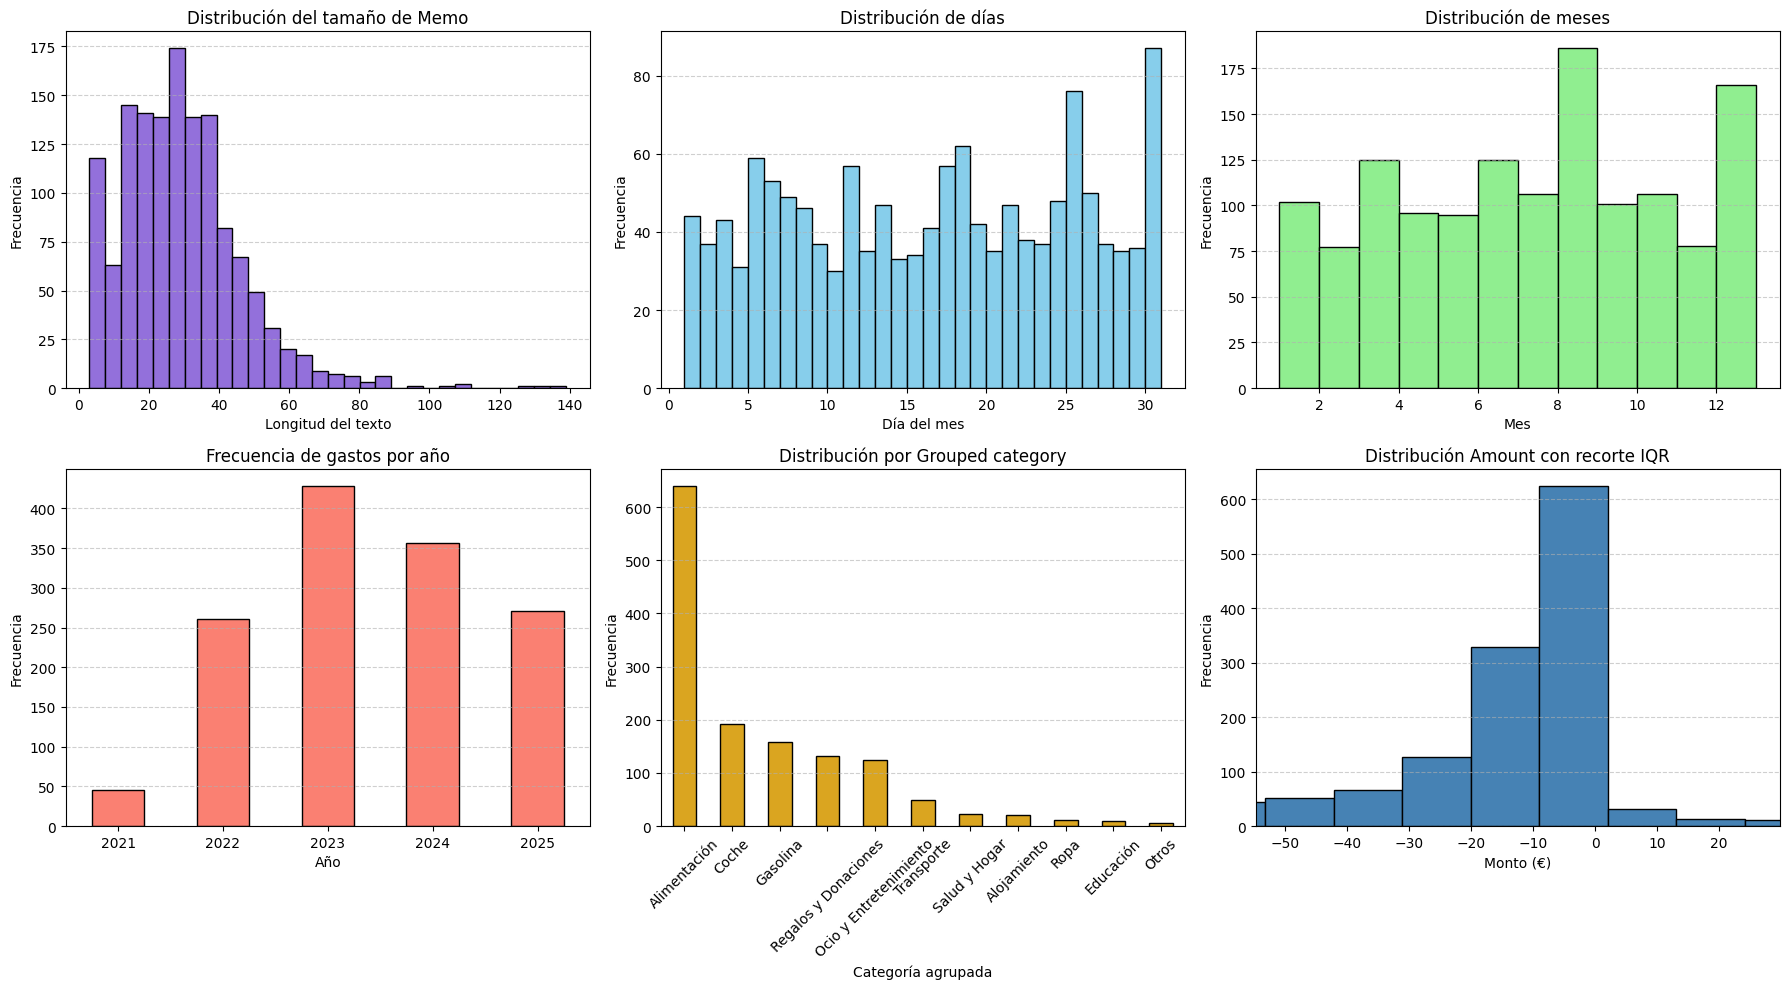

In [179]:
print("La distribución en histogramas de las variables son:")
fig, axes = plt.subplots(2, 3, figsize=(18,10))

# ========== 1. Memo_length ==========
axes[0,0].hist(gastos['Memo_length'], bins=30, edgecolor='black', color='mediumpurple')
axes[0,0].set_title('Distribución del tamaño de Memo')
axes[0,0].set_xlabel('Longitud del texto')
axes[0,0].set_ylabel('Frecuencia')
axes[0,0].grid(axis='y', linestyle='--', alpha=0.6)

# ========== 2. Día ==========
axes[0,1].hist(gastos['Dia'], bins=range(1, 32), edgecolor='black', color='skyblue')
axes[0,1].set_title('Distribución de días')
axes[0,1].set_xlabel('Día del mes')
axes[0,1].set_ylabel('Frecuencia')
axes[0,1].grid(axis='y', linestyle='--', alpha=0.6)

# ========== 3. Mes ==========
axes[0,2].hist(gastos['Mes'], bins=range(1, 14), edgecolor='black', color='lightgreen')
axes[0,2].set_title('Distribución de meses')
axes[0,2].set_xlabel('Mes')
axes[0,2].set_ylabel('Frecuencia')
axes[0,2].grid(axis='y', linestyle='--', alpha=0.6)

# ========== 4. Año ==========
gastos_por_año = gastos['Any'].value_counts().sort_index()
gastos_por_año.plot(kind='bar', ax=axes[1,0], color='salmon', edgecolor='black')
axes[1,0].set_title('Frecuencia de gastos por año')
axes[1,0].set_xlabel('Año')
axes[1,0].set_ylabel('Frecuencia')
axes[1,0].grid(axis='y', linestyle='--', alpha=0.6)
axes[1,0].tick_params(axis='x', rotation=0)

# ========== 5. Grouped category ==========
gastos['Grouped category'].value_counts().plot(kind='bar', ax=axes[1,1],color='goldenrod', edgecolor='black')
axes[1,1].set_title('Distribución por Grouped category')
axes[1,1].set_xlabel('Categoría agrupada')
axes[1,1].set_ylabel('Frecuencia')
axes[1,1].grid(axis='y', linestyle='--', alpha=0.6)
axes[1,1].tick_params(axis='x', rotation=45)

# ========== 6. Amount ==========
Q1 = gastos['Amount'].quantile(0.25)
Q3 = gastos['Amount'].quantile(0.75)
IQR = Q3 - Q1

axes[1,2].hist(gastos['Amount'], bins=2000, edgecolor='black', color='steelblue')
axes[1,2].set_title('Distribución Amount con recorte IQR')
axes[1,2].set_xlabel('Monto (€)')
axes[1,2].set_ylabel('Frecuencia')
axes[1,2].grid(axis='y', linestyle='--', alpha=0.6)
axes[1,2].set_xlim(Q1 - 2*IQR, Q3 + 2*IQR)

plt.tight_layout()
plt.show()

## 3.2 ¿Qué patrones de gasto del usuario se detectan? ¿Cómo varía el gasto a lo largo del tiempo?

/tmp/ipython-input-1894194564.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  expenses['YearMonth'] = expenses['Date'].dt.to_period('M')


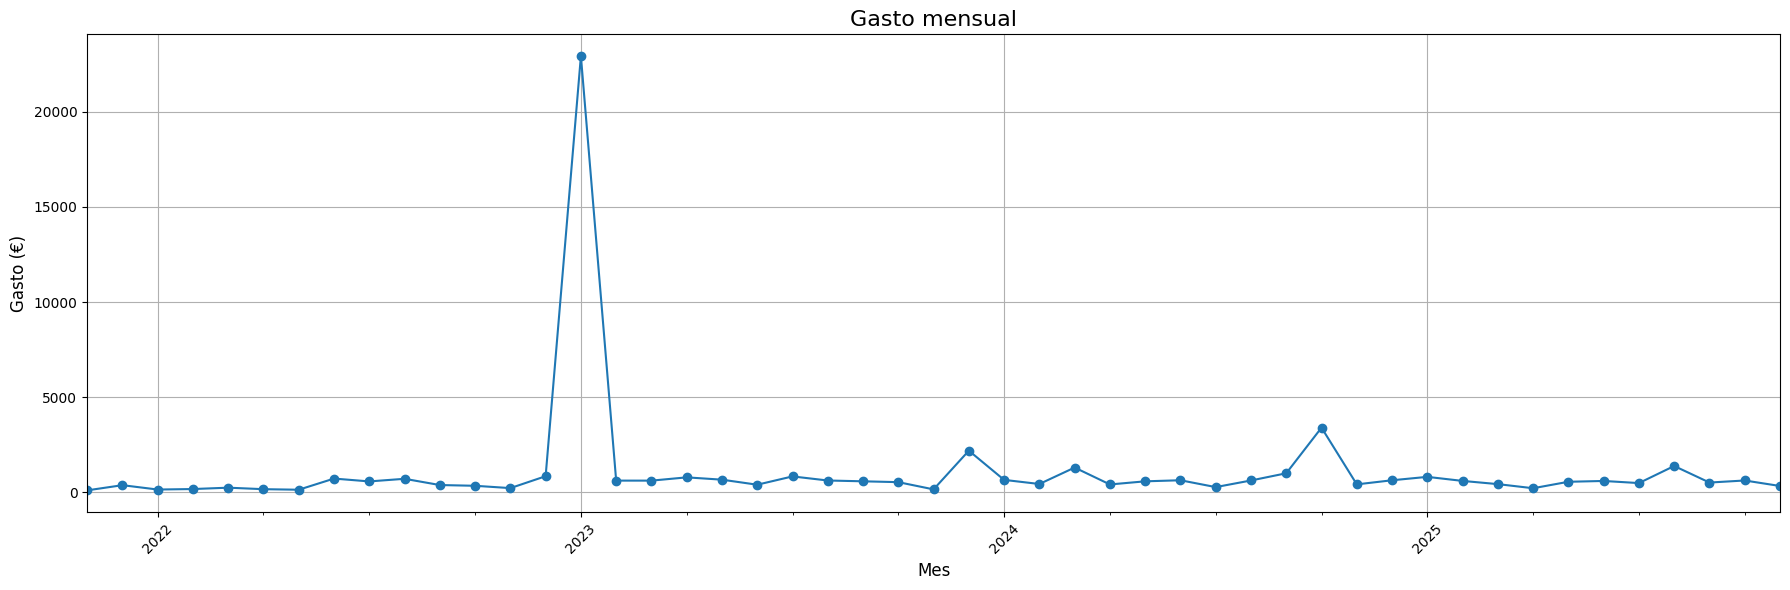

Vemos meses puntuales donde el usuario tuvo grandes gastos.
Eso eclipsa poder ver claramente la evolución del gasto a lo largo de los meses.


In [217]:
# Extraer el año y mes para agrupar por mes
expenses['YearMonth'] = expenses['Date'].dt.to_period('M')

# Agrupar por mes y calcular la suma de 'Amount'
expenses_monthly = expenses.groupby('YearMonth')['Amount'].sum()

# Gráfico de línea
plt.figure(figsize=(18, 6))
abs(expenses_monthly).plot(kind='line', marker='o')
plt.title('Gasto mensual', fontsize=16)
plt.xlabel('Mes', fontsize=12)
plt.ylabel('Gasto (€)', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

print("Vemos meses puntuales donde el usuario tuvo grandes gastos.")
print("Eso eclipsa poder ver claramente la evolución del gasto a lo largo de los meses.")

In [214]:
expenses_sinpuntuales = expenses.copy()

print("Se detecta que hay 4 gastos mucho más altos que el resto, que son unos gastos puntuales no periódicos:\n")
for i in range(4):
    idx = expenses_sinpuntuales['Amount'].idxmin()

    print(
        f"{expenses_sinpuntuales.loc[idx, 'Memo']} = {expenses_sinpuntuales.loc[idx, 'Amount']:.2f} € | "
        f"Fecha: {expenses_sinpuntuales.loc[idx, 'Date'].date()} | "
        f"Categoría: {expenses_sinpuntuales.loc[idx, 'Category']} | "
        f"Categoría agrupada: {expenses_sinpuntuales.loc[idx, 'Grouped category']}"
    )

    # Eliminamos el registro actual
    expenses_sinpuntuales = expenses_sinpuntuales.drop(index=idx)

print("\nSeparamos estos gastos puntuales del resto para un mejor análisi descriptivo de las finanzas")

Se detecta que hay 4 gastos mucho más altos que el resto, que son unos gastos puntuales no periódicos:

Opel Combo Life = -22055.00 € | Fecha: 2023-01-03 | Categoría: Furgo | Categoría agrupada: Coche
Màster Big Data = -3060.00 € | Fecha: 2024-10-22 | Categoría: Education | Categoría agrupada: Educación
Combo. Canvi de marxes de 100 km = -990.00 € | Fecha: 2023-12-01 | Categoría: Car | Categoría agrupada: Coche
Cotxe reparació. Cambi caixa de canvis (350) + oli de caixa (50) + 21% iva, embrage nou by Noé = -484.00 € | Fecha: 2023-12-13 | Categoría: Car | Categoría agrupada: Coche

Separamos estos gastos puntuales del resto para un mejor análisi descriptivo de las finanzas


La distribución mensual del gasto sin los gastos puntuales es la siguiente


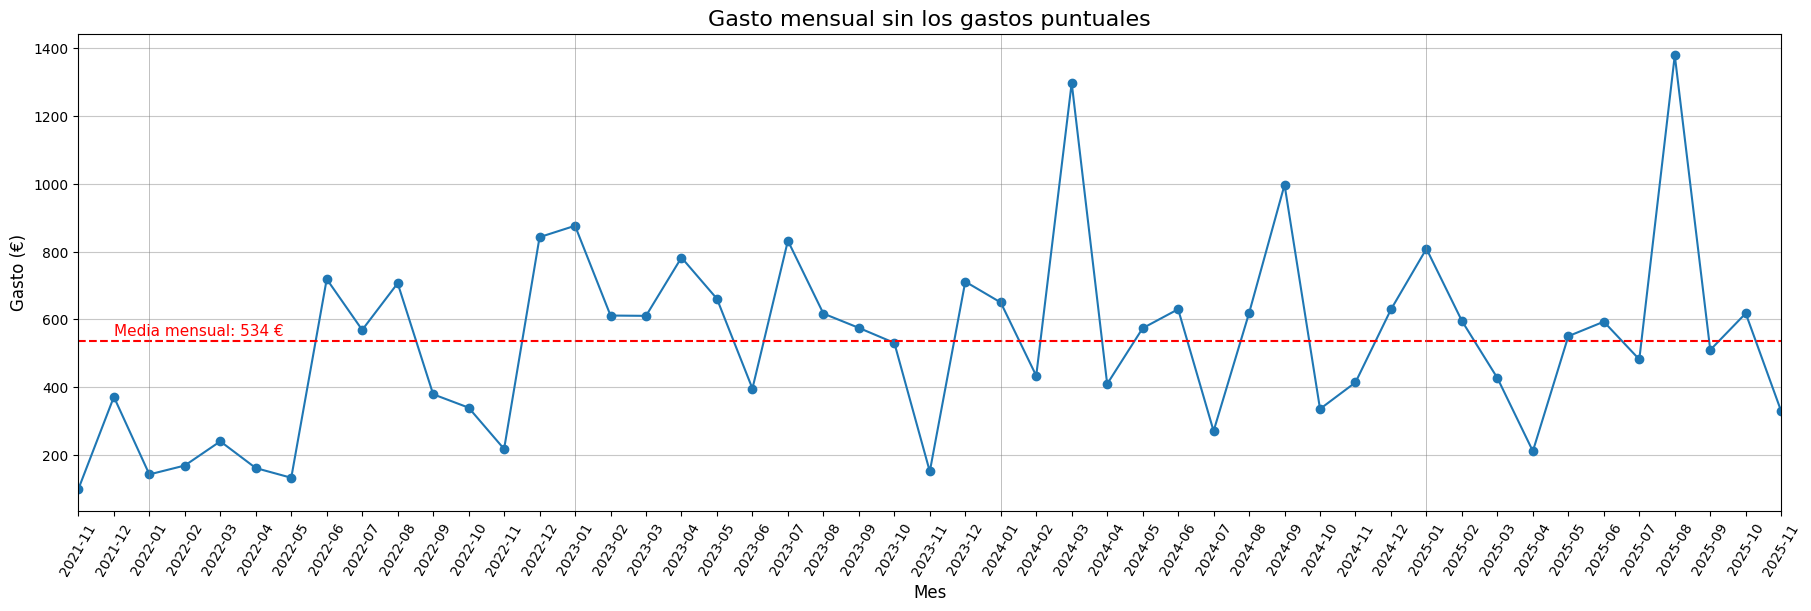

In [216]:
print("La distribución mensual del gasto sin los gastos puntuales es la siguiente")

# Agrupar por mes y calcular la suma de 'Amount'
expenses_sinpuntuales['Date'] = pd.to_datetime(expenses_sinpuntuales['Date'])
expenses_sinpuntuales['YearMonth'] = expenses_sinpuntuales['Date'].dt.to_period('M')
expenses_monthly_sinpuntuales = expenses_sinpuntuales.groupby('YearMonth')['Amount'].sum().abs()

# Preparar índices y etiquetas
x_labels = expenses_monthly_sinpuntuales.index.astype(str)
x_positions = list(range(len(x_labels)))

# Identificar posiciones de los meses de enero (para grid anual)
enero_positions = [i for i, label in enumerate(x_labels) if '-01' in label]

# Crear figura y ejes
fig, ax = plt.subplots(figsize=(18, 6), constrained_layout=True)

# Gráfico de línea
ax.plot(x_positions, expenses_monthly_sinpuntuales.values, marker='o', label='Gasto mensual')

# Línea de la media
media_mensual = expenses_monthly_sinpuntuales.mean()
ax.axhline(media_mensual, color='red', linestyle='--', label=f'Media mensual ({int(media_mensual)} €)')

# Texto para la línea de media
ax.text(
    x=1,
    y=media_mensual + media_mensual * 0.02,
    s=f'Media mensual: {int(media_mensual)} €',
    color='red',
    fontsize=11,
    ha='left',
    va='bottom'
)

# Eje X
ax.set_xticks(x_positions)
ax.set_xticklabels(x_labels, rotation=60)
ax.set_xlim(0, len(x_positions) - 1)

# Añadir grid anual (en enero)
for pos in enero_positions:
    ax.axvline(x=pos, color='gray', linestyle='-', linewidth=0.7, alpha=0.5)

# Eje Y con línea base
ax.grid(False)  # quitar grid general
ax.yaxis.grid(True, linestyle='-', alpha=0.7)  # solo horizontal

# Títulos y etiquetas
ax.set_title('Gasto mensual sin los gastos puntuales', fontsize=16)
ax.set_xlabel('Mes', fontsize=12)
ax.set_ylabel('Gasto (€)', fontsize=12)
plt.show()


## 3.3 ¿Cómo es el gasto del usuario según las categorías?

/tmp/ipython-input-2131992946.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


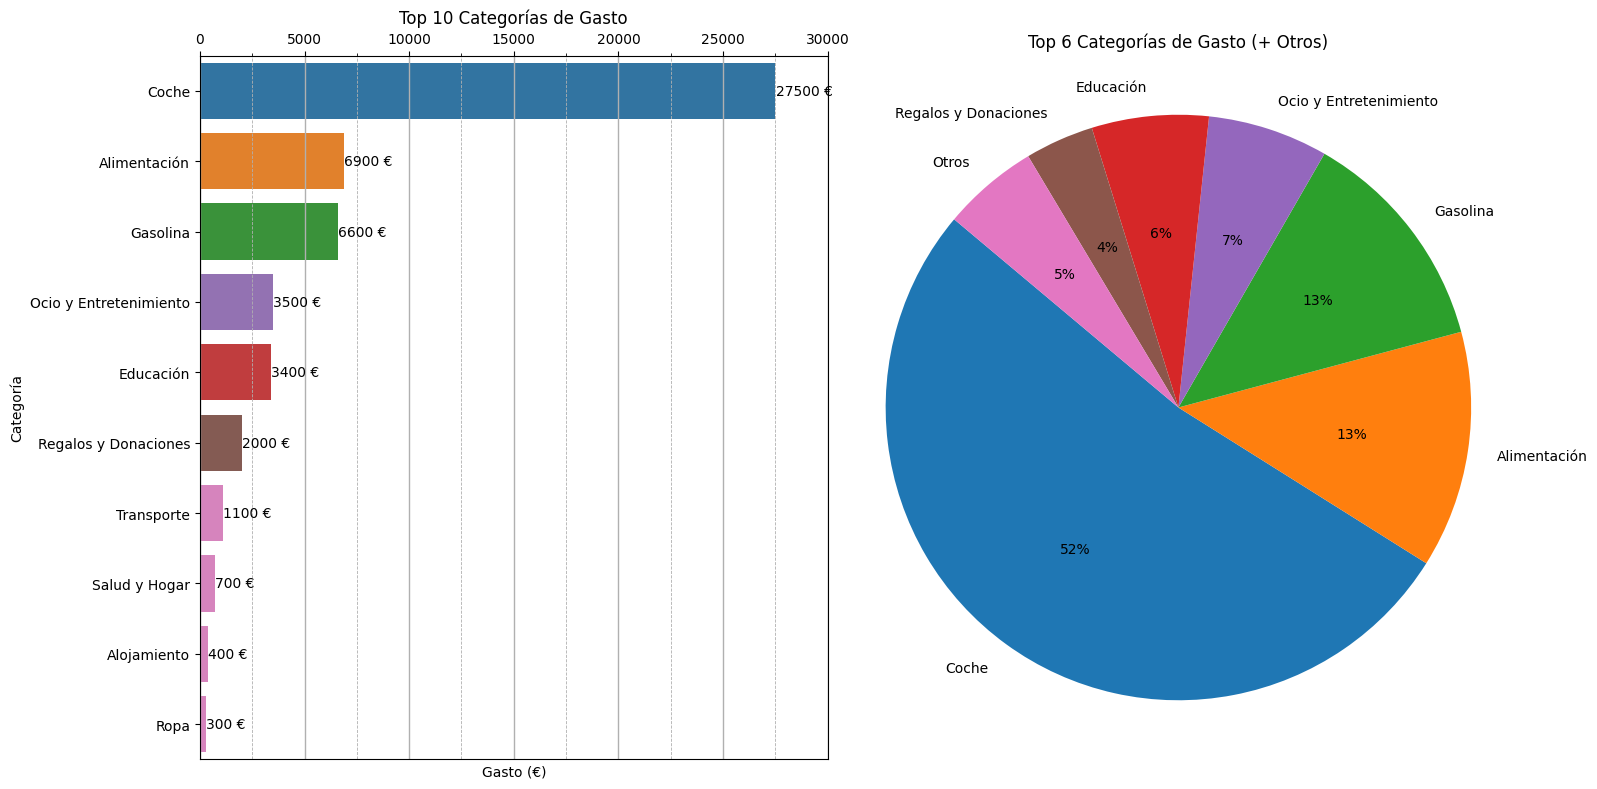

In [209]:
# Sumar el gasto total por categoría, ordenarlo y aplicar valor absoluto y redondeo a centenas
data = expenses.groupby('Grouped category')['Amount'].sum().abs()
data = data.apply(lambda x: np.round(x, -2)).sort_values(ascending=True)

# Paleta de colores personalizada
colores_pie = {
    'Alimentación': '#ff7f0e',
    'Coche': '#1f77b4',
    'Gasolina': '#2ca02c',
    'Ocio y Entretenimiento': '#9467bd',
    'Regalos y Donaciones': '#8c564b',
    'Educación': '#d62728',
    'Transporte': '#e377c2',
    'Salud y Hogar': '#e377c2',
    'Alojamiento': '#e377c2',
    'Ropa': '#e377c2',
    'Otros': '#e377c2'
}

# Asignar colores según el diccionario
colores_ordenados = [colores_pie.get(cat, '#d3d3d3') for cat in data.index]

# Crear figura y subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# --- Barplot (Top 10 categorías) ---
top10_data = data[-10:][::-1]
sns.barplot(
    x=top10_data.values,
    y=top10_data.index,
    palette=colores_ordenados[-10:][::-1],
    ax=axes[0]
)
axes[0].set_title('Top 10 Categorías de Gasto')
axes[0].set_xlabel('Gasto (€)')
axes[0].set_ylabel('Categoría')
axes[0].set_xticks(np.arange(0, data.max() + 5000, 5000), minor=False)
axes[0].set_xticks(np.arange(0, data.max() + 2500, 2500), minor=True)
axes[0].grid(True, axis='x', which='major', linestyle='-', linewidth=1)
axes[0].grid(True, axis='x', which='minor', linestyle='--', linewidth=0.6)
axes[0].xaxis.tick_top()

# Añadir etiquetas con valores redondeados
for i, value in enumerate(top10_data.values):
    axes[0].text(value + 10, i, f'{int(value)} €', va='center')

# --- Pieplot (Top 6 + Otros) ---
top6 = data.sort_values(ascending=False)[:6]
otros_total = np.round(data.sort_values(ascending=False)[6:].sum(), -2)

data_pie = top6.copy()
if otros_total > 0:
    data_pie['Otros'] = otros_total

# Colores para el pie chart
colores_piechart = [colores_pie.get(cat, '#d3d3d3') for cat in data_pie.index]

axes[1].pie(
    data_pie,
    labels=data_pie.index,
    autopct=lambda p: f'{int(np.round(p))}%' if p > 0 else '',
    startangle=140,
    colors=colores_piechart
)
axes[1].set_title('Top 6 Categorías de Gasto (+ Otros)')
axes[1].axis('equal')

plt.tight_layout()
plt.show()

print("Este gráfico permite ver como es el gasto del usuario distribuido en las distintas categorías.")
print("Permite leer el gasto de cada categoría tanto en cantidad como en %")

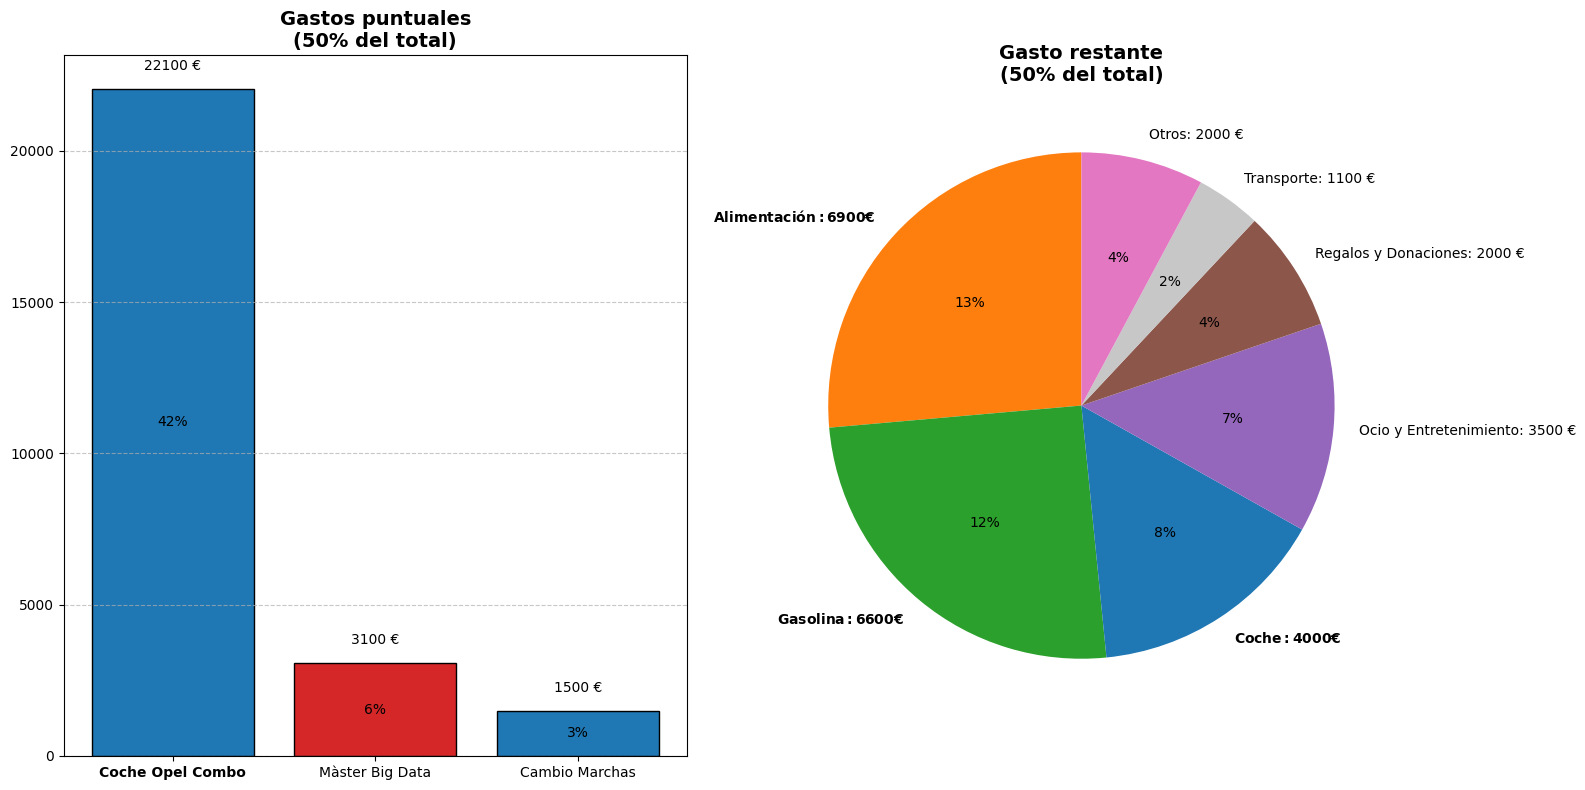

Este gráfico permite ver como es el gasto del usuario. El usuario hizo 3 grandes gastos puntuales que corresponde a la mitad de su gasto.
Se observa la disribución del resto del gasto no puntual por las categorías.
El área de ambas gráficas es proporcional a la cantidad gastada.
El gráfico permite leer la cantidad y el % de cada categoría de gasto.
En el gráfico se destaca en negrita los gastos importantes.


In [206]:
# Paleta personalizada
colores_pie = {
    'Alimentación': '#ff7f0e',
    'Coche': '#1f77b4',
    'Gasolina': '#2ca02c',
    'Ocio y Entretenimiento': '#9467bd',
    'Regalos y Donaciones': '#8c564b',
    'Otros': '#e377c2'
}

# Colores para barras específicas del barplot
colores_barras = {
    'Coche Opel Combo': '#1f77b4',
    'Cambio Marchas': '#1f77b4',
    'Màster Big Data': '#d62728'
}

# Función para redondear a centenas
def round_to_hundreds(x):
    return int(round(x / 100.0) * 100)

# Calcular gasto total original
total_gasto = abs(expenses['Amount'].sum())

# Identificar los 4 gastos más grandes
gastos_ordenados = expenses.sort_values(by='Amount', ascending=True).head(4)
gastos_sinpuntuales = expenses.drop(gastos_ordenados.index)
gastos_puntuales = gastos_ordenados.copy().reset_index(drop=True)

# Agrupar los dos registros del cambio de marchas
mask_cambio_marchas = gastos_puntuales['Memo'].str.contains('Canvi|Cambi', case=False)
fila_cambio_marchas = pd.Series({
    'Memo': 'Cambio Marchas',
    'Amount': gastos_puntuales.loc[mask_cambio_marchas, 'Amount'].sum()
})
otros_gastos = gastos_puntuales[~mask_cambio_marchas].copy()
otros_gastos.loc[otros_gastos['Memo'].str.contains('Opel', case=False, na=True), 'Memo'] = 'Coche Opel Combo'
otros_gastos.loc[otros_gastos['Memo'].str.contains('Máster', case=False, na=True), 'Memo'] = 'Máster Big Data'

nuevos_datos = pd.concat([otros_gastos, pd.DataFrame([fila_cambio_marchas])], ignore_index=True)
nuevos_datos = nuevos_datos[['Memo', 'Amount']]
nuevos_datos.set_index('Memo', inplace=True)

porcentaje_puntuales = (abs(nuevos_datos['Amount'].sum()) / total_gasto) * 100

# --- SUBPLOTS ---
fig, axes = plt.subplots(1, 2, figsize=(16, 8),
                         gridspec_kw={'width_ratios': [1 - porcentaje_puntuales/100, porcentaje_puntuales/100]})

# --- BARPLOT ---
colors = [colores_barras.get(name, '#c7c7c7') for name in nuevos_datos.index]
bars = axes[0].bar(nuevos_datos.index, abs(nuevos_datos['Amount']), color=colors, edgecolor='black')

for bar in bars:
    height = bar.get_height()
    pct = int(round((height / total_gasto) * 100))
    euros = round_to_hundreds(height)

    # Porcentaje dentro de la barra
    axes[0].text(
        bar.get_x() + bar.get_width() / 2,
        height / 2,
        f"{pct}%",
        ha='center', va='center',
        color='black', fontsize=10
    )

    # Euros encima de la barra (redondeados a centenas)
    axes[0].text(
        bar.get_x() + bar.get_width() / 2,
        height + max(total_gasto*0.01, 5),  # un poco por encima para que no se superponga
        f"{euros} €",
        ha='center', va='bottom',
        fontsize=10
    )

# Negrita en etiquetas específicas
xticks = axes[0].get_xticklabels()
for label in xticks:
    if label.get_text() == "Coche Opel Combo":
        label.set_weight('bold')

axes[0].set_title(f"Gastos puntuales\n({int(round(porcentaje_puntuales))}% del total)", fontsize=14, weight='bold')
axes[0].tick_params(axis='x')
axes[0].grid(True, axis='y', linestyle='--', alpha=0.7)

# --- PIE CHART ---
grouped_data = abs(gastos_sinpuntuales.groupby("Grouped category")['Amount'].sum())
top_6 = grouped_data.nlargest(6)
otros = pd.Series(grouped_data[~grouped_data.index.isin(top_6.index)].sum(), index=['Otros'])
final_data = pd.concat([top_6, otros])

# Etiquetas con cantidad en euros redondeada a centenas
labels = []
colors_pie_list = []
for cat in final_data.index:
    cantidad = round_to_hundreds(final_data[cat])
    label = f"{cat}: {cantidad} €"

    if cat in ['Alimentación', 'Gasolina', 'Coche']:
        label = f"$\\bf{{{label}}}$"

    labels.append(label)
    colors_pie_list.append(colores_pie.get(cat, '#c7c7c7'))

# Función para porcentajes respecto al total global
def autopct_global(pct):
    absolute = int(round(pct / 100 * grouped_data.sum()))
    porcentaje_total = absolute / total_gasto * 100
    return f"{int(round(porcentaje_total))}%"

axes[1].pie(
    final_data,
    labels=labels,
    autopct=autopct_global,
    colors=colors_pie_list,
    startangle=90,
    textprops={'fontsize': 10}
)
axes[1].set_title(f"Gasto restante\n({int(round(100 - porcentaje_puntuales))}% del total)", fontsize=14, weight='bold')

plt.tight_layout()
plt.show()


print("Este gráfico permite comprender mejor como es el gasto del usuario al separar los gastos puntuales")
print("El usuario hizo 3 grandes gastos puntuales que corresponde a la mitad de su gasto.")
print("Se observa la distribución del resto del gasto no puntual por las categorías.")
print("El área de ambas gráficas es proporcional a la cantidad gastada.")
print("El gráfico permite leer la cantidad y el % de cada categoría de gasto.")
print("En el gráfico se destaca en negrita los gastos importantes.")

### 3.3.1 Categorias agrupadas más frecuentes

In [180]:
# Cantidad de gastos por categoría
frecuencia = gastos[gastos['Amount'] < 0]['Grouped category'].value_counts()

# Suma de amount gastado por categoría
gasto_total = gastos[gastos['Amount'] < 0].groupby('Grouped category')['Amount'].sum().sort_values()

print("\nCATEGORÍAS AGRUPADAS MÁS FRECUENTES (por cantidad de registros):")
print(frecuencia.head(10))   # Puedes quitar el head si quieres ver todas

print("\nCATEGORÍAS DONDE SE HA GASTADO MÁS DINERO (por Amount total):")
print(gasto_total.head(10))


CATEGORÍAS AGRUPADAS MÁS FRECUENTES (por cantidad de registros):
Grouped category
Alimentación              639
Gasolina                  159
Regalos y Donaciones      131
Coche                     130
Ocio y Entretenimiento    124
Transporte                 49
Salud y Hogar              23
Alojamiento                20
Ropa                       11
Educación                   9
Name: count, dtype: int64

CATEGORÍAS DONDE SE HA GASTADO MÁS DINERO (por Amount total):
Grouped category
Coche                    -27528.78
Alimentación              -6910.98
Gasolina                  -6595.04
Ocio y Entretenimiento    -3504.21
Educación                 -3374.27
Regalos y Donaciones      -2036.03
Transporte                -1089.59
Salud y Hogar              -737.59
Alojamiento                -412.16
Ropa                       -319.90
Name: Amount, dtype: float64


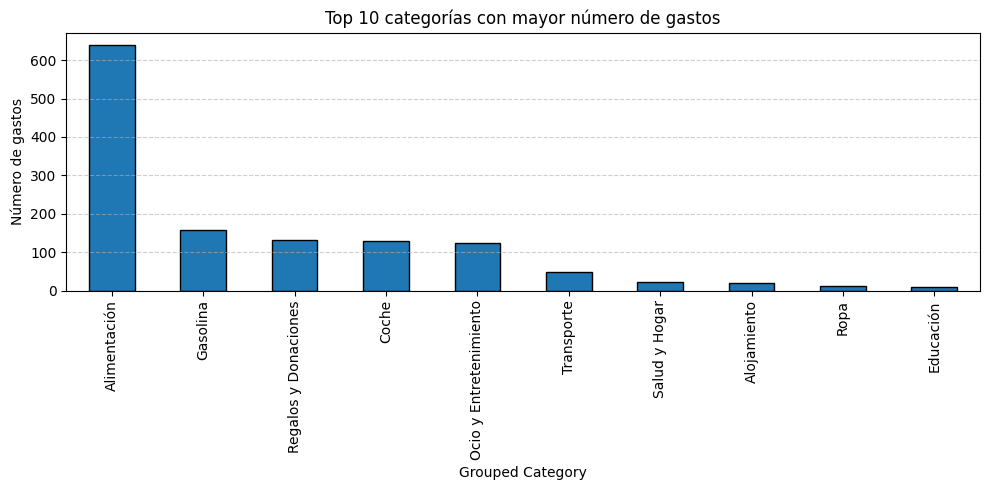

In [181]:
plt.figure(figsize=(10,5))
frecuencia.head(10).plot(kind='bar', edgecolor='black')
plt.title("Top 10 categorías con mayor número de gastos")
plt.ylabel("Número de gastos")
plt.xlabel("Grouped Category")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

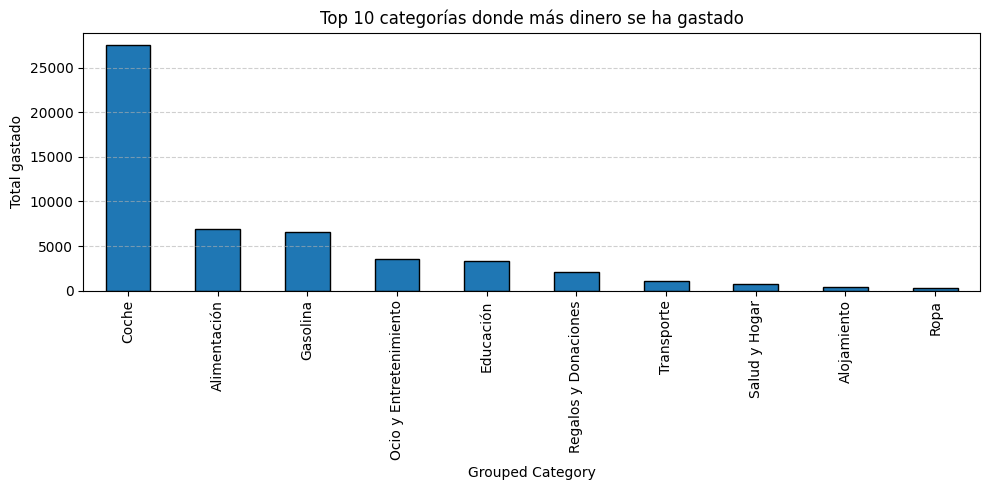

In [182]:
plt.figure(figsize=(10,5))
gasto_total.abs().head(10).plot(kind='bar', edgecolor='black')
plt.title("Top 10 categorías donde más dinero se ha gastado")
plt.ylabel("Total gastado")
plt.xlabel("Grouped Category")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

### 3.3.2 Categorias más frecuentes

In [183]:
# Cantidad de gastos por categoría
frecuencia = gastos[gastos['Amount'] < 0]['Category'].value_counts()

# Suma de amount gastado por categoría
gasto_total = gastos[gastos['Amount'] < 0].groupby('Category')['Amount'].sum().sort_values()

print("\nCATEGORÍAS MÁS FRECUENTES (por cantidad de registros):")
print(frecuencia.head(10))   # Puedes quitar el head si quieres ver todas

print("\nCATEGORÍAS DONDE SE HA GASTADO MÁS DINERO (por Amount total):")
print(gasto_total.head(10))


CATEGORÍAS MÁS FRECUENTES (por cantidad de registros):
Category
Food             396
Gasolina         159
Gift             123
Supermercat       72
Prendre algo      67
Alcohol           59
Peatge            41
Atraccions        41
Snacks            38
Material ruta     36
Name: count, dtype: int64

CATEGORÍAS DONDE SE HA GASTADO MÁS DINERO (por Amount total):
Category
Furgo             -23396.38
Gasolina           -6595.04
Food               -5123.70
Education          -3332.00
Car                -3285.79
Gift               -1400.76
Atraccions         -1128.46
Material ruta      -1113.34
Supermercat         -768.47
Projecte Boscos     -635.27
Name: Amount, dtype: float64


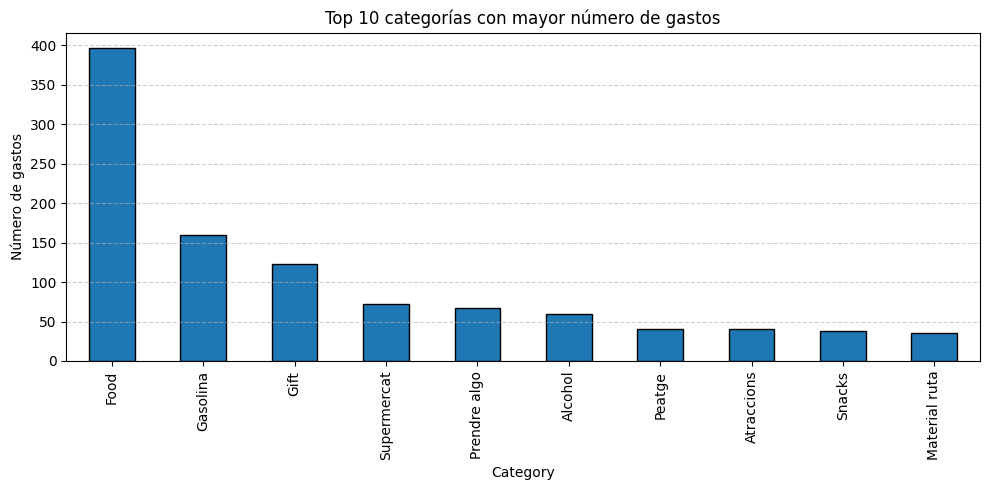

In [184]:
plt.figure(figsize=(10,5))
frecuencia.head(10).plot(kind='bar', edgecolor='black')
plt.title("Top 10 categorías con mayor número de gastos")
plt.ylabel("Número de gastos")
plt.xlabel("Category")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

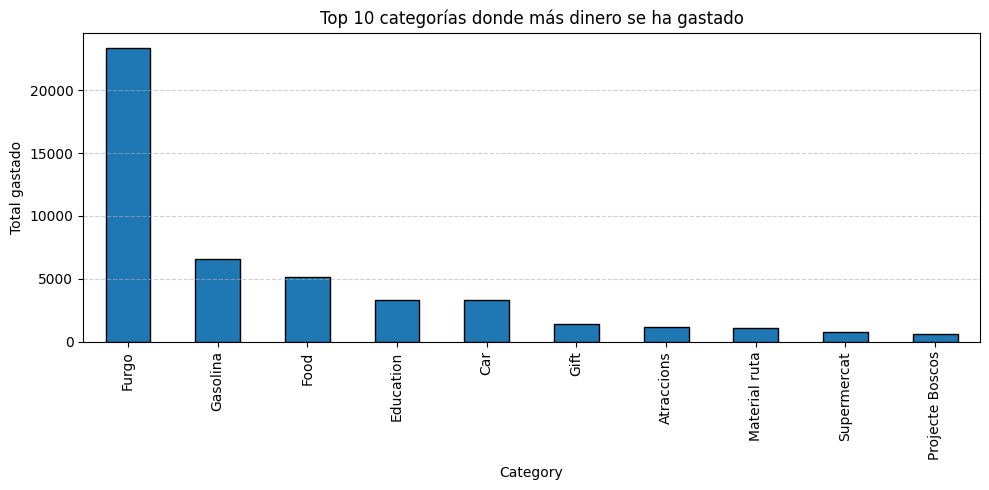

In [185]:
plt.figure(figsize=(10,5))
gasto_total.abs().head(10).plot(kind='bar', edgecolor='black')
plt.title("Top 10 categorías donde más dinero se ha gastado")
plt.ylabel("Total gastado")
plt.xlabel("Category")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

## 3.4 ¿Cómo es el gasto del usuario por concepto?

Con concepto nos referimos a subcategoría dentro de las palabras en "Memo"

/tmp/ipython-input-1997560197.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frecuencia', y='Palabra', data=df_palabras, palette='viridis')


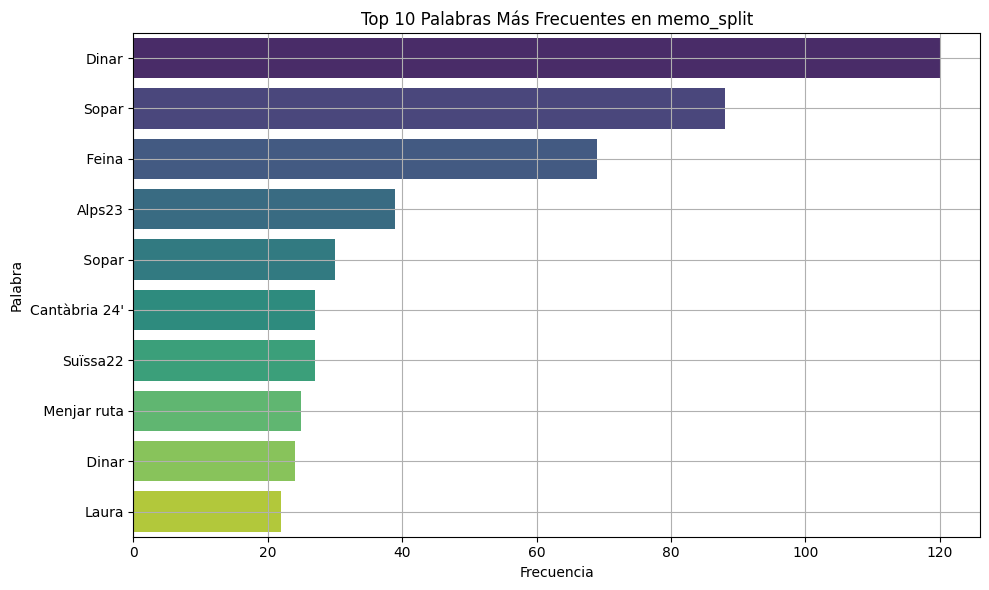

In [218]:
from collections import Counter

# Aplanar todas las listas de 'memo_split' para contar frecuencias
todas_palabras = [palabra for sublist in expenses_sinpuntuales['memo_split'] for palabra in sublist]

# Contar las ocurrencias de cada palabra
contador_palabras = Counter(todas_palabras)

# Obtener las 10 palabras más frecuentes
palabras_mas_frecuentes = contador_palabras.most_common(10)

# Crear un DataFrame para facilitar la visualización
df_palabras = pd.DataFrame(palabras_mas_frecuentes, columns=['Palabra', 'Frecuencia'])

# Generar el barplot
plt.figure(figsize=(10, 6))
sns.barplot(x='Frecuencia', y='Palabra', data=df_palabras, palette='viridis')
plt.title('Top 10 Palabras Más Frecuentes en memo_split')
plt.xlabel('Frecuencia')
plt.ylabel('Palabra')
plt.grid(True)
plt.tight_layout()
plt.show()

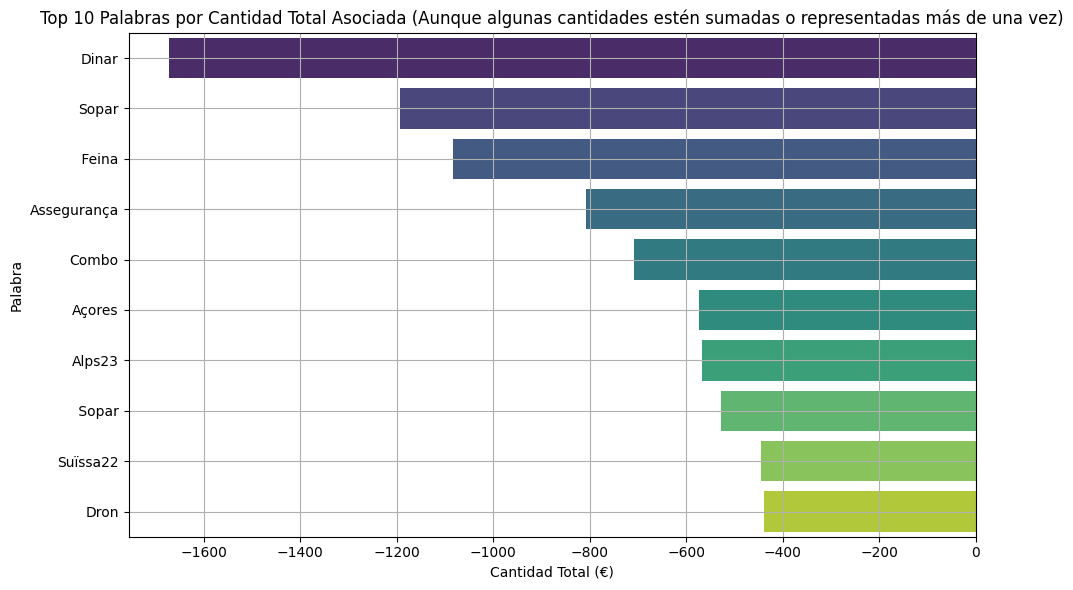

In [219]:
from collections import defaultdict
palabras_cantidad = defaultdict(float)

# Iterar sobre las filas del DataFrame
for _, row in expenses_sinpuntuales.iterrows():
    # Desanidar las listas de palabras y asociar la cantidad
    words = row['memo_split']
    amount = row['Amount']
    for word in words:
        palabras_cantidad[word] += amount

# Convertir el resultado en un DataFrame
df_palabras = pd.DataFrame(list(palabras_cantidad.items()), columns=['Palabra', 'TotalAmount'])

# Ordenar por 'TotalAmount' y seleccionar las 10 principales
top_10_palabras = df_palabras.sort_values(by='TotalAmount', ascending=True).head(10)

# Generar el barplot
plt.figure(figsize=(10, 6))
sns.barplot(x='TotalAmount', y='Palabra', hue='Palabra', dodge=False, data=top_10_palabras, palette='viridis', legend=False)
plt.title('Top 10 Palabras por Cantidad Total Asociada (Aunque algunas cantidades estén sumadas o representadas más de una vez)')
plt.xlabel('Cantidad Total (€)')
plt.ylabel('Palabra')
plt.grid(True)
plt.tight_layout()
plt.show()

# 4 Conclusiones exploratorias

## 4.1 Hallazgos en la exploración de datos

- Las **dimensiones** del dataset son de 1402 datos y de 5 valores columnares.
- Los **tipos** de todos datos del dataset son correctos excepto la fecha.
- Se verifica que los datos de tipo objeto que deberían ser strings, son strings.
- Se verifica que los datos decimales monetarios tienen como máximo dos decimales.
- Se determina el **dominio** de las variables explorando en cada una de ellas las estadísticas de mínimo, máximo, frecuencia, valores únicos, longitudes de carácteres.
- Se verifica que los valores en Income/Expenses solo son esos dos.
- Se estudia la agregación o individualidad (**granularidad**) de los datos observándose 10 gastos de la misma fecha-categoría-cantidad, la mayoría de los datos individuales habiendo alguna agrupación de moda 2 gastos por fecha o un día con 21 gastos.
- Se verifica que no hay ningún **valor nulo** en ninguna columna.
- Se encuentra un registro **duplicado**.
- Se estudia la **distribución** de cada variable: quartiles, mediana, promedio, diagrama de cajas y bigotes. Se descubre una distribución bastante uniforme en fechas. Hay una distribución de 94 % de gastos frente a un 6% de compartición de gastos. Se estudia la distribución frecuencial de las categorías. Se halla que la mitad de los gastos están entre 20,61 € y 3,81 € hallándose la mitad de esos entre 8,87 € y 3,81 €.
- Se encuentran datos **outliers** a partir de la distribución.
- Se verifica la **normalización** de las fechas y que todas sean válidas. Se halla la no normalización de las categorías en idioma y estándarización.
- Se comprueban las **incoherencias** de fechas. Se encuentran valores incoherentemente asignados por el usuario en las categorías.

## 4.2 Cambios aplicados durante la limpieza de datos

- Se cambió el **formato** de fecha a datetime.
- Se trataron los **outliers** de datos incorrectos eliminándolos.
- Se trataron los **outliers** de datos con categorías incoherentes para el análisi, eliminando en algunos casos o reassignando su categoría de forma correcta en otros casos.
- Se trataron las entradas de gastos **duplicados** eliminándolos.
- Se **normalizaron** las categorías en idioma, en estandarización y agrupación de 48 categorías a 11.
- Se **normalizó** el texto abierto del usuario 'Memo' en listas para poder detectar palabras clave para el análisi.

## 4.3 Principales hallazgos en la visualización de los datos

Las visualizaciones realizadas permiten describir de forma muy completa y con un análisi muy profundo las finanzas personales del usuario. Los visuales nos brindan gran información. Sin embargo en este apartado se resumen solo los principales hallazgos.

Se destacan los **gastos puntuales** del usuario:
- Compra del coche: 42 % del gasto total en 4 años, 22.100 €.
- Reparación del coche: alrededor de 1.500 €.
- Máster / educación: gasto puntual en octubre 2024.

Se descubren las principales **categorías** de gasto:
- El coche y transporte representan el principal, un 67%, gasto del usuario. Hay distintos gastos implicados aquí: Compra del coche, reparación, gasolina, revisiones e ITV y transporte que llegan a sumar 35.300 € (67 % del total).
- Alimentación representa un 13 % del gasto con 6.900 €.
- Ocio y entretenimiento: 7 %, 3.500 €.
- Regalos y donaciones: 4 %, 2.000 €.

Se descubre la **evolución temporal** del gasto:
- A parte de los tres grandes gastos puntuales que sobresalen, el gasto mensual es más o menos regular. Se promedia un gasto de 534 €/mes, oscilando típicamete entre 200 y 900 €. En dos raras veces superando los 1000 €, llegando hasta 1400€
- Hay una tendencia estacional: ligero aumento del gasto en invierno (dic-feb) y disminución del gasto post-verano (sep-nov).
- Hay unos gastos recurrentes importantes: seguro del coche anual en enero (300-400 €), revisiones mecánicas (unos 200 € cada 6 meses), regalos y donaciones en Navidad, julio y febrero.